In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import ray.rllib.agents.ddpg.td3 as td3
import ray.rllib.agents.ars as ars
import xarray as xr

from run_rllib import PPOCTrainer, PPOFracTrainer, A2CCTrainer, A2CFracTrainer, ARSCTrainer, ARSFracTrainer
string_2_trainer = {"PPOC":PPOCTrainer, "PPOFrac":PPOFracTrainer, "A2CC":A2CCTrainer, \
                    "A2CFrac":A2CFracTrainer, "ARSC":ARSCTrainer, "ARSFrac":ARSFracTrainer}

import ray.rllib.agents.sac as sac
import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D
#from simple_pid import PID

import dill
import pickle5 as pickle
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import itertools
%matplotlib inline

import pandas as pd
from multiprocessing import Pool
from itertools import product
from seagul.plot import smooth_bounded_curve
import os
import time
import re
from seagul.mesh import mesh_dim

import time
import torch
#jup_dir = "/home/sgillen/work/"
#jup_dir = "/home/sgillen/"

Instructions for updating:
non-resource variables are not supported in the long term


/home/sgillen/work/seagul/seagul/envs/__init__.py:49: UserWarning: Warning, pybullet envs not installed
  warnings.warn("Warning, pybullet envs not installed")


In [2]:
def mdim_stable(obs, act, rew):
    m = None

    if obs.shape[0] == 1000:
        gait_start = 200
        target_obs = obs[gait_start:]
    else:
        m = obs.shape[1] / 2

    if m is None:
        m, _, _, _ = mesh_dim(target_obs)
        m = np.clip(m, .1, obs.shape[1] / 2)

    return m

base_dir = os.getcwd() + "/simple_fr0/"

trainer_dict = {}

        
def get_config_and_df(checkpoint_path, plt_reward=False):
    config_path =  '/'.join(checkpoint_path.split('/')[:-2]) + '/params.pkl'
    config = pickle.load(open(config_path, 'rb'))
    env_name = config['env']


    csv_path = '/'.join(checkpoint_path.split('/')[:-2]) + '/progress.csv'
    df = pd.read_csv(csv_path)
    if plt_reward:
        plt.plot(df['episode_reward_mean'])
        plt.figure()
        
    return config, df
    
    

for trainer_dir in os.scandir(base_dir):
    trainer_name = trainer_dir.path.split("/")[-1].split("_")[0]
    print("trainer_name: ", trainer_name)
    for run_dir in os.scandir(trainer_dir.path):
        env_name = re.search("env=([a-zA-Z1-9\-])+", run_dir.path)
        try:
            env_name = env_name.group(0).split("=")[1]
            for run_file in os.scandir(run_dir.path):
                if "checkpoint_" in run_file.path:
                    checkpoint_path = f"{run_file.path}/checkpoint-{run_file.path.split('_')[-1].lstrip('0')}"
                    #print(checkpoint_path)


                    if trainer_name not in trainer_dict:
                        trainer_dict[trainer_name] = {env_name:[checkpoint_path]}
                    else:
                        if env_name not in trainer_dict[trainer_name]:
                            trainer_dict[trainer_name][env_name] = [checkpoint_path]
                        else:
                            trainer_dict[trainer_name][env_name].append(checkpoint_path)


        except AttributeError:
            print(f"excepting {run_dir.path} from run_dirs")

trainer_name:  PPOFrac
excepting /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/experiment_state-2021-05-06_19-14-11.json from run_dirs
excepting /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/basic-variant-state-2021-05-06_19-14-11.json from run_dirs
trainer_name:  PPOC


In [3]:
env_names = list(trainer_dict["PPOC"].keys())
num_seeds = len(list(trainer_dict["PPOC"].values())[0])
num_runs = 10

mdims = xr.DataArray(np.zeros((len(trainer_dict), len(env_names), num_seeds, num_runs)),
                dims = ("trainer", "env", "seed", "run"),
                coords = {"trainer": list(trainer_dict.keys()), "env":env_names})

cdims = xr.DataArray(np.zeros((len(trainer_dict), len(env_names), num_seeds, num_runs)),
                dims = ("trainer", "env", "seed", "run"),
                coords = {"trainer": list(trainer_dict.keys()), "env":env_names})

rews = xr.DataArray(np.zeros((len(trainer_dict), len(env_names), num_seeds, num_runs)),
                dims = ("trainer", "env", "seed", "run"),
                coords = {"trainer": list(trainer_dict.keys()), "env":env_names})

mdims_stable = xr.DataArray(np.zeros((len(trainer_dict), len(env_names), num_seeds, num_runs)),
                dims = ("trainer", "env", "seed", "run"),
                coords = {"trainer": list(trainer_dict.keys()), "env":env_names})


def do_rollout_rllib(env, trainer, num_steps=1000, render=False, deterministic=False):
    with torch.no_grad():
        act_list = []
        obs_list = []
        rew_list = []
        x_list = []

        obs = env.reset()
        done = False
        obs_size = env.observation_space.shape[0]
        act_size = env.action_space.shape[0]

        filter_t = 0
        policy_t = 0
        env_t = 0
        for cur_step in range(num_steps):

            if render:
                env.render()
                time.sleep(.005)

            obs_list.append(np.copy(obs))

            x_list.append(env.unwrapped.sim.data.qpos[0])

            start = time.time()
            #obs_n = trainer.workers.local_worker().filters['default_policy'](obs)
            filter_t +=  time.time() - start; start = time.time()

            samples, _, out_dict = trainer.compute_action(obs, full_fetch=True)
            means = out_dict['action_dist_inputs']
            means = means[:len(means)//2]
            
            if deterministic:
                act = means
            else:
                act = samples
            policy_t +=  time.time() - start; start = time.time()

            obs, rew, done, _ = env.step(act)
            env_t +=  time.time() - start; start = time.time()


            #act_list.append(np.copy(act))
            rew_list.append(rew)

        print(f"Rollout Ts: \n {filter_t} \n {policy_t} \n {env_t}")


        ep_length = len(rew_list)
        ep_obs = np.stack(obs_list)
        ep_act = np.stack(act_list)
        ep_rew = np.array(rew_list)
        ep_rew = ep_rew.reshape(-1, 1)

        return ep_obs, ep_act, ep_rew, x_list

In [4]:
ep_length = 1000
ray.shutdown()
ray.init(log_to_driver=False)
#ray.init(logging_level="DEBUG")

for trainer_name in trainer_dict.keys():
    trainer = None

    for env_name in trainer_dict[trainer_name].keys():
        trainer = None
        for i, checkpoint_path in enumerate(trainer_dict[trainer_name][env_name]):
            for j in range(num_runs):
                print(trainer_name, env_name, i, j)

                print(checkpoint_path)
                config, df = get_config_and_df(checkpoint_path)
                start = time.time()

                if trainer is None:
                    trainer = string_2_trainer[trainer_name](config)

                config["reuse_actors"] = True
                trainer.reset_config(config)
                trainer.restore(checkpoint_path)
                env = trainer.env_creator({})
                print("restore", time.time() - start); start = time.time()

                


                o,a,r,l = do_rollout_rllib(env, trainer, num_steps=ep_length,deterministic=True)
                print("rollout",  time.time() - start); start = time.time()

                o_norm = trainer.workers.local_worker().filters['default_policy'](o)
                
                
                target = o[200:]
                target = trainer.workers.local_worker().filters['default_policy'](target)


                print("filter", time.time() - start); start = time.time()


                rews.loc[trainer_name, env_name,i,j] = sum(r).item()
                mdims.loc[trainer_name, env_name,i,j], cdims.loc[trainer_name, env_name,i,j] , _, _ = mesh_dim(target, init_d=1e-6)
                mdims_stable.loc[trainer_name, env_name,i,j] = mdim_stable(o_norm, a,r)

                print(trainer.workers.local_worker().filters['default_policy'])
                #trainer.get_policy().observation_filter(trainer.env_creator({}).reset())
                print(f"{checkpoint_path} restored")

#trainer = PPOCTrainer(config)
#trainer = ppo.PPOTrainer(config)#, config['env_name'])
#trainer = td3.TD3Trainer(config)
#trainer = ddpg.DDPGTrainer(config)
#trainer = sac.SACTrainer(config)
#trainer = ars.ARSTrainer(config)
#trainer.restore(checkpoint_path)

2021-05-10 13:00:51,145	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8266
2021-05-10 13:00:53,361	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


PPOFrac HalfCheetah-v2 0 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304


2021-05-10 13:01:01,721	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:01,724	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48506.13149237633, '_episodes_total': 20064}


running build_ext
restore 11.4090735912323
Rollout Ts: 
 0.00012087821960449219 
 1.1154627799987793 
 0.09848451614379883
rollout 1.224362850189209
filter 0.03221249580383301


2021-05-10 13:01:06,358	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:06,359	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48506.13149237633, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26809383913709467, mean_std=3.5196049522796025), (n=1800, mean_mean=0.31933678419513456, mean_std=3.3885956134377246))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 0 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02519702911376953
Rollout Ts: 
 0.00013566017150878906 
 1.2222282886505127 
 0.10273623466491699
rollout 1.3350679874420166
filter 0.03586220741271973


2021-05-10 13:01:08,094	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:08,096	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48506.13149237633, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2680937032158672, mean_std=3.5196089482408985), (n=1800, mean_mean=0.3178200644352801, mean_std=3.4325211208704096))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 0 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02703714370727539
Rollout Ts: 
 0.00011587142944335938 
 1.0612056255340576 
 0.08772468566894531
rollout 1.159433126449585
filter 0.030034542083740234


2021-05-10 13:01:09,632	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:09,634	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48506.13149237633, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26809315956580826, mean_std=3.5196093933311206), (n=1800, mean_mean=0.31175357430832423, mean_std=3.4420093012932007))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 0 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.024729490280151367
Rollout Ts: 
 0.0001068115234375 
 1.110107183456421 
 0.09115147590637207
rollout 1.2119214534759521
filter 0.043154001235961914


2021-05-10 13:01:11,276	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:11,278	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48506.13149237633, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26809302855572326, mean_std=3.5196065272643833), (n=1800, mean_mean=0.3102916570853353, mean_std=3.4076903557730853))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 0 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.023541927337646484
Rollout Ts: 
 0.0001232624053955078 
 1.067683219909668 
 0.08828425407409668
rollout 1.1659600734710693
filter 0.03723597526550293


2021-05-10 13:01:12,833	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:12,834	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48506.13149237633, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26809323987579015, mean_std=3.5196086175958876), (n=1800, mean_mean=0.31264973849078154, mean_std=3.4284465564647286))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 0 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02669835090637207
Rollout Ts: 
 0.00012350082397460938 
 1.1531705856323242 
 0.09773731231689453
rollout 1.2610251903533936
filter 0.03101968765258789


2021-05-10 13:01:14,498	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:14,499	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48506.13149237633, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26809334211904484, mean_std=3.5196084243961274), (n=1800, mean_mean=0.3137906519977083, mean_std=3.428253685365636))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 0 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.018903732299804688
Rollout Ts: 
 0.00012087821960449219 
 1.0702626705169678 
 0.09337544441223145
rollout 1.1737401485443115
filter 0.034636497497558594


2021-05-10 13:01:16,098	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:16,099	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48506.13149237633, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26809331799883607, mean_std=3.5196065968525425), (n=1800, mean_mean=0.3135214990633054, mean_std=3.4089156397773155))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 0 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.024373292922973633
Rollout Ts: 
 0.000110626220703125 
 1.0180697441101074 
 0.08911252021789551
rollout 1.1159141063690186
filter 0.031725168228149414


2021-05-10 13:01:17,669	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:17,671	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48506.13149237633, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26809279820002363, mean_std=3.519606016334714), (n=1800, mean_mean=0.30772116056551096, mean_std=3.401830619131833))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 0 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.021605968475341797
Rollout Ts: 
 0.00012111663818359375 
 1.0394649505615234 
 0.09090876579284668
rollout 1.1397156715393066
filter 0.030870676040649414


2021-05-10 13:01:19,248	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:19,250	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48506.13149237633, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26809307080517475, mean_std=3.5196077483301944), (n=1800, mean_mean=0.31076311086610453, mean_std=3.421591187744798))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 0 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02971339225769043
Rollout Ts: 
 0.00010943412780761719 
 1.0401651859283447 
 0.09363913536071777
rollout 1.1437125205993652
filter 0.03712630271911621


2021-05-10 13:01:20,908	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:20,912	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48481.62586021423, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2680936720700426, mean_std=3.519609384156209), (n=1800, mean_mean=0.3174725139563382, mean_std=3.4385576363107626))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00002_2_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.025255918502807617
Rollout Ts: 
 0.00012040138244628906 
 1.3958120346069336 
 0.10138154029846191
rollout 1.5077905654907227
filter 0.03652143478393555


2021-05-10 13:01:22,873	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:22,874	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48481.62586021423, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26135866489264264, mean_std=3.570409153492072), (n=1800, mean_mean=0.3043355999990953, mean_std=3.4607410880529774))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 1 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.026825666427612305
Rollout Ts: 
 0.00011754035949707031 
 1.0011866092681885 
 0.08761072158813477
rollout 1.0987780094146729
filter 0.038610219955444336


2021-05-10 13:01:24,436	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:24,438	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48481.62586021423, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26135861125393606, mean_std=3.570412866222575), (n=1800, mean_mean=0.30373705563574027, mean_std=3.502858474191022))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 1 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.0265505313873291
Rollout Ts: 
 0.00011348724365234375 
 1.0246210098266602 
 0.0889277458190918
rollout 1.123361349105835
filter 0.030165672302246094


2021-05-10 13:01:26,025	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:26,026	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48481.62586021423, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26135875068433206, mean_std=3.57041058421359), (n=1800, mean_mean=0.3052929335515433, mean_std=3.475348746327625))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 1 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.022202730178833008
Rollout Ts: 
 0.00011134147644042969 
 1.008857250213623 
 0.08762669563293457
rollout 1.1063659191131592
filter 0.03391575813293457


2021-05-10 13:01:27,488	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:27,489	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48481.62586021423, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26135874017768285, mean_std=3.570410504377223), (n=1800, mean_mean=0.3051756918019241, mean_std=3.4748158911181015))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 1 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02489614486694336
Rollout Ts: 
 0.00012254714965820312 
 1.221374273300171 
 0.10371279716491699
rollout 1.3362910747528076
filter 0.04134178161621094


2021-05-10 13:01:29,215	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:29,216	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48481.62586021423, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2613579384650019, mean_std=3.5704134572731694), (n=1800, mean_mean=0.29622952875495345, mean_std=3.510864473383415))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 1 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.01953601837158203
Rollout Ts: 
 0.00012803077697753906 
 1.105546474456787 
 0.08950424194335938
rollout 1.2046616077423096
filter 0.028957843780517578


2021-05-10 13:01:30,809	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:30,810	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48481.62586021423, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2613588359703877, mean_std=3.570409660695969), (n=1800, mean_mean=0.3062446248088481, mean_std=3.4624801096010622))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 1 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02267003059387207
Rollout Ts: 
 0.00011897087097167969 
 1.0882415771484375 
 0.09058356285095215
rollout 1.1881377696990967
filter 0.02993464469909668


2021-05-10 13:01:32,353	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:32,354	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48481.62586021423, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2613586028859329, mean_std=3.570409785427527), (n=1800, mean_mean=0.3036436786334429, mean_std=3.4675884303736866))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 1 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02806687355041504
Rollout Ts: 
 0.00011944770812988281 
 1.0886189937591553 
 0.09161496162414551
rollout 1.1908996105194092
filter 0.03625297546386719


2021-05-10 13:01:33,909	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:33,910	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48481.62586021423, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26135866690898374, mean_std=3.5704078211697734), (n=1800, mean_mean=0.3043580999764535, mean_std=3.444209434672217))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 1 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.020236968994140625
Rollout Ts: 
 0.00012230873107910156 
 1.0674946308135986 
 0.0924680233001709
rollout 1.1696598529815674
filter 0.030349254608154297


2021-05-10 13:01:35,573	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:35,575	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48481.62586021423, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26135872973989854, mean_std=3.570409306410166), (n=1800, mean_mean=0.30505921849716394, mean_std=3.4614690036266618))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 1 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.023164033889770508
Rollout Ts: 
 0.00011396408081054688 
 1.0255627632141113 
 0.08895015716552734
rollout 1.1239421367645264
filter 0.03832745552062988


2021-05-10 13:01:37,171	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
2021-05-10 13:01:37,172	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48618.46716451645, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2613589643797773, mean_std=3.570409255099237), (n=1800, mean_mean=0.30767752136663173, mean_std=3.46128289974358))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00005_5_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
restore 0.018912315368652344
Rollout Ts: 
 0.00011849403381347656 
 1.0390205383300781 
 0.08969259262084961
rollout 1.1385233402252197
filter 0.03536105155944824


2021-05-10 13:01:38,772	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
2021-05-10 13:01:38,773	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48618.46716451645, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2467121866524825, mean_std=3.500405511899889), (n=1800, mean_mean=0.2916480088632909, mean_std=3.402946350342169))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 2 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
restore 0.024707555770874023
Rollout Ts: 
 0.00011849403381347656 
 1.0361390113830566 
 0.09067606925964355
rollout 1.136345624923706
filter 0.03375124931335449


2021-05-10 13:01:40,342	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
2021-05-10 13:01:40,348	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48618.46716451645, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24671206328188802, mean_std=3.5004075943019224), (n=1800, mean_mean=0.29027133928934334, mean_std=3.421691247316666))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 2 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
restore 0.03542184829711914
Rollout Ts: 
 0.00011467933654785156 
 1.042271614074707 
 0.09305405616760254
rollout 1.1454017162322998
filter 0.030446767807006836


2021-05-10 13:01:41,916	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
2021-05-10 13:01:41,917	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48618.46716451645, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2467117032405987, mean_std=3.500409492878538), (n=1800, mean_mean=0.28625370534878886, mean_std=3.444785379708086))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 2 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
restore 0.023414134979248047
Rollout Ts: 
 0.00011754035949707031 
 1.0939817428588867 
 0.0905296802520752
rollout 1.1939685344696045
filter 0.03068375587463379


2021-05-10 13:01:43,474	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
2021-05-10 13:01:43,476	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48618.46716451645, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24671112550498614, mean_std=3.50040811852127), (n=1800, mean_mean=0.2798068608555536, mean_std=3.4324638763466226))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 2 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
restore 0.023582935333251953
Rollout Ts: 
 0.00012445449829101562 
 1.1208033561706543 
 0.09127354621887207
rollout 1.2221651077270508
filter 0.03494691848754883


2021-05-10 13:01:45,090	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
2021-05-10 13:01:45,091	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48618.46716451645, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24671125532591098, mean_std=3.500408199840906), (n=1800, mean_mean=0.2812555084689657, mean_std=3.429546242583582))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 2 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
restore 0.019242048263549805
Rollout Ts: 
 0.00013184547424316406 
 1.2554454803466797 
 0.10594844818115234
rollout 1.372039794921875
filter 0.030059099197387695


2021-05-10 13:01:46,849	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
2021-05-10 13:01:46,851	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48618.46716451645, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24671212743910723, mean_std=3.5004068304018543), (n=1800, mean_mean=0.29098725779519147, mean_std=3.412250208385577))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 2 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
restore 0.025885820388793945
Rollout Ts: 
 0.00012063980102539062 
 1.1088852882385254 
 0.09370851516723633
rollout 1.213719129562378
filter 0.03891491889953613


2021-05-10 13:01:48,446	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
2021-05-10 13:01:48,447	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48618.46716451645, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24671191653326818, mean_std=3.50040948033851), (n=1800, mean_mean=0.2886337986717708, mean_std=3.4459995229326372))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 2 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
restore 0.025136947631835938
Rollout Ts: 
 0.00012540817260742188 
 1.1012365818023682 
 0.09083771705627441
rollout 1.2030048370361328
filter 0.0325314998626709


2021-05-10 13:01:50,022	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
2021-05-10 13:01:50,023	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48618.46716451645, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24671235700575966, mean_std=3.500407855586831), (n=1800, mean_mean=0.29354894947887944, mean_std=3.426386923378122))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 2 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
restore 0.02057623863220215
Rollout Ts: 
 0.0001308917999267578 
 1.123072624206543 
 0.09522128105163574
rollout 1.229017972946167
filter 0.030998706817626953


2021-05-10 13:01:51,613	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
2021-05-10 13:01:51,614	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48618.46716451645, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24671130355880683, mean_std=3.500406437090348), (n=1800, mean_mean=0.2817937303976117, mean_std=3.4122188390634984))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 2 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304
restore 0.023312807083129883
Rollout Ts: 
 0.00011920928955078125 
 1.0398907661437988 
 0.09460139274597168
rollout 1.144629955291748
filter 0.030794143676757812


2021-05-10 13:01:53,211	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:53,213	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48509.80522274971, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24671187871616523, mean_std=3.5004061221502734), (n=1800, mean_mean=0.28821180463421786, mean_std=3.4062305174640226))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00011_11_env=HalfCheetah-v2_2021-05-07_08-51-49/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.020843029022216797
Rollout Ts: 
 0.00012302398681640625 
 1.0647614002227783 
 0.09315967559814453
rollout 1.167447805404663
filter 0.03075695037841797


2021-05-10 13:01:54,811	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:54,812	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48509.80522274971, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.23138368265166487, mean_std=3.5970043646407697), (n=1800, mean_mean=0.37721860249765066, mean_std=3.8925051508249395))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 3 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.024543046951293945
Rollout Ts: 
 0.00012493133544921875 
 1.0718882083892822 
 0.09379434585571289
rollout 1.1757161617279053
filter 0.03177928924560547


2021-05-10 13:01:56,424	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:56,425	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48509.80522274971, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.231384398408892, mean_std=3.597003841243522), (n=1800, mean_mean=0.3852056045731946, mean_std=3.8855949460455754))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 3 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.019962787628173828
Rollout Ts: 
 0.00011348724365234375 
 1.018991231918335 
 0.09189701080322266
rollout 1.1209166049957275
filter 0.03762221336364746


2021-05-10 13:01:57,977	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:57,979	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48509.80522274971, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.23138351914369903, mean_std=3.5969991757968462), (n=1800, mean_mean=0.37539404744157284, mean_std=3.848800976950423))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 3 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.023223400115966797
Rollout Ts: 
 0.00011706352233886719 
 1.0623178482055664 
 0.09302616119384766
rollout 1.1654095649719238
filter 0.04369783401489258


2021-05-10 13:01:59,512	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:01:59,513	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48509.80522274971, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2313839041468917, mean_std=3.5970018642506405), (n=1800, mean_mean=0.37969022663157137, mean_std=3.870750748072744))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 3 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.022113323211669922
Rollout Ts: 
 0.00016236305236816406 
 1.1473939418792725 
 0.10168004035949707
rollout 1.2597596645355225
filter 0.03506898880004883


2021-05-10 13:02:01,413	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:02:01,419	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48509.80522274971, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.23138401196807323, mean_std=3.5970053214972526), (n=1800, mean_mean=0.3808933831902785, mean_std=3.90268504501068))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 3 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.08133149147033691
Rollout Ts: 
 0.00013208389282226562 
 1.1966447830200195 
 0.11529827117919922
rollout 1.3286855220794678
filter 0.030802011489868164


2021-05-10 13:02:03,198	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:02:03,200	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48509.80522274971, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.231384440580058, mean_std=3.5970068434356497), (n=1800, mean_mean=0.3856761847973723, mean_std=3.911779891645099))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 3 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.023010969161987305
Rollout Ts: 
 0.0001354217529296875 
 1.1234562397003174 
 0.09777164459228516
rollout 1.2311210632324219
filter 0.03596043586730957


2021-05-10 13:02:04,940	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:02:04,941	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48509.80522274971, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2313835220007367, mean_std=3.5969995134531514), (n=1800, mean_mean=0.3754259285967215, mean_std=3.8504153928863056))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 3 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.018682479858398438
Rollout Ts: 
 0.00012803077697753906 
 1.4466822147369385 
 0.09727668762207031
rollout 1.5542304515838623
filter 0.03592395782470703


2021-05-10 13:02:06,856	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:02:06,857	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48509.80522274971, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.231383967542492, mean_std=3.5970031750486955), (n=1800, mean_mean=0.38039764637740825, mean_std=3.883171673053703))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 3 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.020595312118530273
Rollout Ts: 
 0.0001239776611328125 
 1.145024061203003 
 0.09732198715209961
rollout 1.2519137859344482
filter 0.031266212463378906


2021-05-10 13:02:08,452	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:02:08,454	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48509.80522274971, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.23138393725966508, mean_std=3.5969987340007927), (n=1800, mean_mean=0.3800597259307455, mean_std=3.839037472646951))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac HalfCheetah-v2 3 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_HalfCheetah-v2_e98ad_00008_8_env=HalfCheetah-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.01927471160888672
Rollout Ts: 
 0.00011205673217773438 
 1.1284174919128418 
 0.09520149230957031
rollout 1.2343699932098389
filter 0.031098365783691406
MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.23138416577170218, mean_std=3.5970006127589054), (n=1800, mean_mean=0.3826096493463741, mean_std=3.8533050105290605))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_1

2021-05-10 13:02:16,488	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:02:16,490	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49880.600227832794, '_episodes_total': 54662}


restore 6.470744371414185
Rollout Ts: 
 0.00013065338134765625 
 1.1767587661743164 
 0.2158200740814209
rollout 1.4046852588653564
filter 0.034563541412353516


2021-05-10 13:02:18,509	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:02:18,511	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49880.600227832794, '_episodes_total': 54662}


MeanStdFilter((17,), True, True, None, (n=20107472, mean_mean=0.14339520368282083, mean_std=2.501954333798454), (n=1800, mean_mean=0.244983690473402, mean_std=2.2421334742824164))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 0 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.03155803680419922
Rollout Ts: 
 0.00013947486877441406 
 1.2591609954833984 
 0.21761226654052734
rollout 1.4881043434143066
filter 0.030278682708740234


2021-05-10 13:02:20,416	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:02:20,416	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49880.600227832794, '_episodes_total': 54662}


MeanStdFilter((17,), True, True, None, (n=20107472, mean_mean=0.14339557819393148, mean_std=2.5019540453755353), (n=1800, mean_mean=0.24916728585227468, mean_std=2.237387428820987))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 0 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.01876544952392578
Rollout Ts: 
 0.00012731552124023438 
 1.2687945365905762 
 0.21485018730163574
rollout 1.495577096939087
filter 0.03018784523010254


2021-05-10 13:02:22,440	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:02:22,441	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49880.600227832794, '_episodes_total': 54662}


MeanStdFilter((17,), True, True, None, (n=20107472, mean_mean=0.14339508185743477, mean_std=2.5019533644544967), (n=1800, mean_mean=0.2436228012859018, mean_std=2.2300681221910006))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 0 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02311420440673828
Rollout Ts: 
 0.0001392364501953125 
 1.2052206993103027 
 0.22101163864135742
rollout 1.43943190574646
filter 0.04354715347290039


2021-05-10 13:02:24,431	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:02:24,432	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49880.600227832794, '_episodes_total': 54662}


MeanStdFilter((17,), True, True, None, (n=20107472, mean_mean=0.1433957191394864, mean_std=2.5019543118941194), (n=1800, mean_mean=0.25074176296548323, mean_std=2.2406817565459383))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 0 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02273869514465332
Rollout Ts: 
 0.0001392364501953125 
 1.2800164222717285 
 0.21718311309814453
rollout 1.509918212890625
filter 0.03712821006774902


2021-05-10 13:02:26,397	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:02:26,398	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49880.600227832794, '_episodes_total': 54662}


MeanStdFilter((17,), True, True, None, (n=20107472, mean_mean=0.14339472080430848, mean_std=2.501954092627332), (n=1800, mean_mean=0.23958954260272575, mean_std=2.2387081209080804))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 0 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02147674560546875
Rollout Ts: 
 0.00014495849609375 
 1.267991542816162 
 0.21510982513427734
rollout 1.4955987930297852
filter 0.03544473648071289


2021-05-10 13:02:28,454	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:02:28,455	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49880.600227832794, '_episodes_total': 54662}


MeanStdFilter((17,), True, True, None, (n=20107472, mean_mean=0.1433951968368102, mean_std=2.5019537113609225), (n=1800, mean_mean=0.24490721493337522, mean_std=2.234497379923237))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 0 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.018450498580932617
Rollout Ts: 
 0.00012087821960449219 
 1.103935718536377 
 0.20604872703552246
rollout 1.3212294578552246
filter 0.03052806854248047


2021-05-10 13:02:30,283	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:02:30,284	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49880.600227832794, '_episodes_total': 54662}


MeanStdFilter((17,), True, True, None, (n=20107472, mean_mean=0.14339517147684125, mean_std=2.5019535337072702), (n=1800, mean_mean=0.24462392334111294, mean_std=2.2318264793700613))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 0 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.022494077682495117
Rollout Ts: 
 0.00014543533325195312 
 1.2751719951629639 
 0.219681978225708
rollout 1.5074479579925537
filter 0.031003236770629883


2021-05-10 13:02:32,229	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:02:32,230	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49880.600227832794, '_episodes_total': 54662}


MeanStdFilter((17,), True, True, None, (n=20107472, mean_mean=0.14339494271037387, mean_std=2.501954212291328), (n=1800, mean_mean=0.2420684148195809, mean_std=2.2397095037877373))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 0 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.023500680923461914
Rollout Ts: 
 0.00012564659118652344 
 1.2118182182312012 
 0.20117640495300293
rollout 1.4245014190673828
filter 0.03005194664001465


2021-05-10 13:02:34,194	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:02:34,195	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49880.600227832794, '_episodes_total': 54662}


MeanStdFilter((17,), True, True, None, (n=20107472, mean_mean=0.14339575245675398, mean_std=2.501953853657985), (n=1800, mean_mean=0.25111394407069165, mean_std=2.233985026854934))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 0 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02592945098876953
Rollout Ts: 
 0.00015091896057128906 
 1.2115046977996826 
 0.21924376487731934
rollout 1.4421308040618896
filter 0.02997303009033203


2021-05-10 13:02:36,170	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
2021-05-10 13:02:36,171	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 50327.58153128624, '_episodes_total': 54004}


MeanStdFilter((17,), True, True, None, (n=20107472, mean_mean=0.14339505212771192, mean_std=2.501953838189435), (n=1800, mean_mean=0.24329069596944972, mean_std=2.234981145323765))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00000_0_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
restore 0.023696184158325195
Rollout Ts: 
 0.00012946128845214844 
 1.2801954746246338 
 0.21823835372924805
rollout 1.5117225646972656
filter 0.04615163803100586


2021-05-10 13:02:38,102	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
2021-05-10 13:02:38,103	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 50327.58153128624, '_episodes_total': 54004}


MeanStdFilter((17,), True, True, None, (n=20102809, mean_mean=0.13505207716877402, mean_std=2.4492598762896742), (n=1800, mean_mean=0.19060258704467467, mean_std=2.1571911166451536))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 1 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
restore 0.022796154022216797
Rollout Ts: 
 0.00013375282287597656 
 1.2761943340301514 
 0.21598553657531738
rollout 1.5054636001586914
filter 0.031829118728637695


2021-05-10 13:02:40,127	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
2021-05-10 13:02:40,128	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 50327.58153128624, '_episodes_total': 54004}


MeanStdFilter((17,), True, True, None, (n=20102809, mean_mean=0.1350522390728318, mean_std=2.4492604219043916), (n=1800, mean_mean=0.1924107683561628, mean_std=2.1623516012675505))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 1 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
restore 0.02598261833190918
Rollout Ts: 
 0.0001308917999267578 
 1.1819419860839844 
 0.21521902084350586
rollout 1.4090406894683838
filter 0.037297964096069336


2021-05-10 13:02:42,070	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
2021-05-10 13:02:42,072	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 50327.58153128624, '_episodes_total': 54004}


MeanStdFilter((17,), True, True, None, (n=20102809, mean_mean=0.13505180522496454, mean_std=2.44925989116844), (n=1800, mean_mean=0.18756545678077696, mean_std=2.1567703725855853))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 1 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
restore 0.024068832397460938
Rollout Ts: 
 0.00015020370483398438 
 1.3553736209869385 
 0.2277979850769043
rollout 1.5976736545562744
filter 0.03506159782409668


2021-05-10 13:02:44,087	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
2021-05-10 13:02:44,088	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 50327.58153128624, '_episodes_total': 54004}


MeanStdFilter((17,), True, True, None, (n=20102809, mean_mean=0.1350525434941482, mean_std=2.4492600378185765), (n=1800, mean_mean=0.1958106147808328, mean_std=2.1576864007549803))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 1 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
restore 0.02342057228088379
Rollout Ts: 
 0.0001380443572998047 
 1.22914457321167 
 0.20754766464233398
rollout 1.448441982269287
filter 0.035299062728881836


2021-05-10 13:02:46,137	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
2021-05-10 13:02:46,139	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 50327.58153128624, '_episodes_total': 54004}


MeanStdFilter((17,), True, True, None, (n=20102809, mean_mean=0.13505228802987645, mean_std=2.4492599950440983), (n=1800, mean_mean=0.1929575317502368, mean_std=2.157003734208046))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 1 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
restore 0.02348041534423828
Rollout Ts: 
 0.00013494491577148438 
 1.2155523300170898 
 0.2064669132232666
rollout 1.4343287944793701
filter 0.0305025577545166


2021-05-10 13:02:48,000	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
2021-05-10 13:02:48,001	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 50327.58153128624, '_episodes_total': 54004}


MeanStdFilter((17,), True, True, None, (n=20102809, mean_mean=0.13505210946027624, mean_std=2.449259887280955), (n=1800, mean_mean=0.19096322588502526, mean_std=2.1570970431995447))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 1 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
restore 0.027992725372314453
Rollout Ts: 
 0.00013828277587890625 
 1.2516062259674072 
 0.21675920486450195
rollout 1.4800405502319336
filter 0.03645730018615723


2021-05-10 13:02:49,907	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
2021-05-10 13:02:49,908	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 50327.58153128624, '_episodes_total': 54004}


MeanStdFilter((17,), True, True, None, (n=20102809, mean_mean=0.13505217151060156, mean_std=2.449260180985245), (n=1800, mean_mean=0.19165621800969207, mean_std=2.1606066433809974))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 1 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
restore 0.022879838943481445
Rollout Ts: 
 0.000156402587890625 
 1.3099970817565918 
 0.22818493843078613
rollout 1.5503060817718506
filter 0.030844688415527344


2021-05-10 13:02:52,063	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
2021-05-10 13:02:52,064	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 50327.58153128624, '_episodes_total': 54004}


MeanStdFilter((17,), True, True, None, (n=20102809, mean_mean=0.135052314315958, mean_std=2.44925976048241), (n=1800, mean_mean=0.19325110068069254, mean_std=2.154844198968873))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 1 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
restore 0.0245668888092041
Rollout Ts: 
 0.00014734268188476562 
 1.3401203155517578 
 0.2258925437927246
rollout 1.5780818462371826
filter 0.030699968338012695


2021-05-10 13:02:54,071	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
2021-05-10 13:02:54,071	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 50327.58153128624, '_episodes_total': 54004}


MeanStdFilter((17,), True, True, None, (n=20102809, mean_mean=0.13505204042559563, mean_std=2.4492601683301047), (n=1800, mean_mean=0.19019223088075327, mean_std=2.160956113309944))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 1 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302
restore 0.02164173126220703
Rollout Ts: 
 0.0001499652862548828 
 1.2686424255371094 
 0.21506333351135254
rollout 1.4966461658477783
filter 0.03777933120727539


2021-05-10 13:02:56,182	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
2021-05-10 13:02:56,186	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49610.24089384079, '_episodes_total': 81074}


MeanStdFilter((17,), True, True, None, (n=20102809, mean_mean=0.13505187849889427, mean_std=2.449259776183782), (n=1800, mean_mean=0.18838379668116784, mean_std=2.155396370011527))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00009_9_env=Walker2d-v2_2021-05-07_08-42-30/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
restore 0.02878427505493164
Rollout Ts: 
 0.00014591217041015625 
 1.3362197875976562 
 0.23079967498779297
rollout 1.5804448127746582
filter 0.02955770492553711


2021-05-10 13:02:58,172	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
2021-05-10 13:02:58,173	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49610.24089384079, '_episodes_total': 81074}


MeanStdFilter((17,), True, True, None, (n=20127287, mean_mean=0.12139184463676983, mean_std=2.4474121641573596), (n=1800, mean_mean=0.1829363677148318, mean_std=1.893378075161892))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303 restored
PPOFrac Walker2d-v2 2 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
restore 0.021924257278442383
Rollout Ts: 
 0.00013756752014160156 
 1.2655744552612305 
 0.21615314483642578
rollout 1.4940059185028076
filter 0.036872148513793945


2021-05-10 13:03:00,223	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
2021-05-10 13:03:00,224	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49610.24089384079, '_episodes_total': 81074}


MeanStdFilter((17,), True, True, None, (n=20127287, mean_mean=0.12139212874511335, mean_std=2.4474120826185657), (n=1800, mean_mean=0.18611321780655873, mean_std=1.8926221504650635))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303 restored
PPOFrac Walker2d-v2 2 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
restore 0.026511430740356445
Rollout Ts: 
 0.0001456737518310547 
 1.1689667701721191 
 0.22504305839538574
rollout 1.4543955326080322
filter 0.04346942901611328


2021-05-10 13:03:02,251	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
2021-05-10 13:03:02,252	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49610.24089384079, '_episodes_total': 81074}


MeanStdFilter((17,), True, True, None, (n=20127287, mean_mean=0.12139194816342448, mean_std=2.4474116611184393), (n=1800, mean_mean=0.18409398476900848, mean_std=1.8858678654048144))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303 restored
PPOFrac Walker2d-v2 2 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
restore 0.019369840621948242
Rollout Ts: 
 0.0001418590545654297 
 1.428924322128296 
 0.2098522186279297
rollout 1.6507854461669922
filter 0.03160238265991211


2021-05-10 13:03:04,479	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
2021-05-10 13:03:04,481	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49610.24089384079, '_episodes_total': 81074}


MeanStdFilter((17,), True, True, None, (n=20127287, mean_mean=0.12139187322751649, mean_std=2.447412002425746), (n=1800, mean_mean=0.18325606447393558, mean_std=1.8914826481072755))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303 restored
PPOFrac Walker2d-v2 2 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
restore 0.029428958892822266
Rollout Ts: 
 0.0001373291015625 
 1.1105260848999023 
 0.21172761917114258
rollout 1.3345370292663574
filter 0.04259133338928223


2021-05-10 13:03:06,416	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
2021-05-10 13:03:06,418	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49610.24089384079, '_episodes_total': 81074}


MeanStdFilter((17,), True, True, None, (n=20127287, mean_mean=0.12139180060585743, mean_std=2.44741208671067), (n=1800, mean_mean=0.18244402171113136, mean_std=1.8918036930309565))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303 restored
PPOFrac Walker2d-v2 2 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
restore 0.026529788970947266
Rollout Ts: 
 0.0001354217529296875 
 1.3685624599456787 
 0.22610163688659668
rollout 1.607656478881836
filter 0.032381296157836914


2021-05-10 13:03:08,490	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
2021-05-10 13:03:08,491	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49610.24089384079, '_episodes_total': 81074}


MeanStdFilter((17,), True, True, None, (n=20127287, mean_mean=0.12139188686581755, mean_std=2.4474120129792274), (n=1800, mean_mean=0.1834085655746383, mean_std=1.8914108177003524))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303 restored
PPOFrac Walker2d-v2 2 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
restore 0.026643991470336914
Rollout Ts: 
 0.0001652240753173828 
 1.451305627822876 
 0.2341907024383545
rollout 1.6992888450622559
filter 0.03250551223754883


2021-05-10 13:03:10,841	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
2021-05-10 13:03:10,842	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49610.24089384079, '_episodes_total': 81074}


MeanStdFilter((17,), True, True, None, (n=20127287, mean_mean=0.12139180916504629, mean_std=2.447412115903425), (n=1800, mean_mean=0.1825397290654101, mean_std=1.8911816543740547))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303 restored
PPOFrac Walker2d-v2 2 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
restore 0.028166532516479492
Rollout Ts: 
 0.00015735626220703125 
 1.3908145427703857 
 0.23427677154541016
rollout 1.6434569358825684
filter 0.030939102172851562


2021-05-10 13:03:13,037	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
2021-05-10 13:03:13,038	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49610.24089384079, '_episodes_total': 81074}


MeanStdFilter((17,), True, True, None, (n=20127287, mean_mean=0.1213918046111385, mean_std=2.4474120185029022), (n=1800, mean_mean=0.18248880806368384, mean_std=1.8913004630167123))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303 restored
PPOFrac Walker2d-v2 2 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
restore 0.02393054962158203
Rollout Ts: 
 0.00012636184692382812 
 1.1623315811157227 
 0.21852445602416992
rollout 1.3937809467315674
filter 0.040906667709350586


2021-05-10 13:03:15,037	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
2021-05-10 13:03:15,037	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49610.24089384079, '_episodes_total': 81074}


MeanStdFilter((17,), True, True, None, (n=20127287, mean_mean=0.12139209367639789, mean_std=2.4474119474763296), (n=1800, mean_mean=0.1857210855238323, mean_std=1.8905712989409391))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303 restored
PPOFrac Walker2d-v2 2 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303
restore 0.02176380157470703
Rollout Ts: 
 0.00012755393981933594 
 1.209848165512085 
 0.2045269012451172
rollout 1.4261503219604492
filter 0.041222572326660156


2021-05-10 13:03:16,893	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:03:16,894	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49673.64636492729, '_episodes_total': 58378}


MeanStdFilter((17,), True, True, None, (n=20127287, mean_mean=0.12139188278056459, mean_std=2.447411950952333), (n=1800, mean_mean=0.18336288499879874, mean_std=1.8906322556524544))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00003_3_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000303/checkpoint-303 restored
PPOFrac Walker2d-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.027044296264648438
Rollout Ts: 
 0.00018286705017089844 
 1.3111732006072998 
 0.2508232593536377
rollout 1.5764360427856445
filter 0.0308687686920166


2021-05-10 13:03:19,256	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:03:19,257	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49673.64636492729, '_episodes_total': 58378}


MeanStdFilter((17,), True, True, None, (n=20075916, mean_mean=0.13907162508351004, mean_std=2.388667092058347), (n=1800, mean_mean=0.02689631273089904, mean_std=1.3673408122989021))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 3 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.025955677032470703
Rollout Ts: 
 0.00014209747314453125 
 1.2078955173492432 
 0.21219110488891602
rollout 1.4322874546051025
filter 0.03148984909057617


2021-05-10 13:03:21,189	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:03:21,190	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49673.64636492729, '_episodes_total': 58378}


MeanStdFilter((17,), True, True, None, (n=20075916, mean_mean=0.13908229522425053, mean_std=2.3886717461212172), (n=1800, mean_mean=0.14590345117629713, mean_std=2.004062494869419))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 3 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02693772315979004
Rollout Ts: 
 0.00015473365783691406 
 1.3615810871124268 
 0.23297905921936035
rollout 1.6072955131530762
filter 0.03122711181640625


2021-05-10 13:03:23,548	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:03:23,549	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49673.64636492729, '_episodes_total': 58378}


MeanStdFilter((17,), True, True, None, (n=20075916, mean_mean=0.13907365807774835, mean_std=2.3887075426383317), (n=1800, mean_mean=0.04957088026558429, mean_std=1.870732478394229))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 3 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.023620128631591797
Rollout Ts: 
 0.00016450881958007812 
 1.433948040008545 
 0.25835728645324707
rollout 1.707937479019165
filter 0.04413247108459473


2021-05-10 13:03:26,031	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:03:26,032	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49673.64636492729, '_episodes_total': 58378}


MeanStdFilter((17,), True, True, None, (n=20075916, mean_mean=0.13907085438440991, mean_std=2.388672663813727), (n=1800, mean_mean=0.01830048474344495, mean_std=1.4763524511128845))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 3 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02875518798828125
Rollout Ts: 
 0.00015115737915039062 
 1.3540229797363281 
 0.23571395874023438
rollout 1.6047089099884033
filter 0.03735613822937012


2021-05-10 13:03:28,307	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:03:28,310	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49673.64636492729, '_episodes_total': 58378}


MeanStdFilter((17,), True, True, None, (n=20075916, mean_mean=0.1390772548375121, mean_std=2.388669371848064), (n=1800, mean_mean=0.08968657298603865, mean_std=1.7601596004905458))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 3 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02583932876586914
Rollout Ts: 
 0.00014090538024902344 
 1.182915449142456 
 0.23591327667236328
rollout 1.4302608966827393
filter 0.03056931495666504


2021-05-10 13:03:30,537	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:03:30,538	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49673.64636492729, '_episodes_total': 58378}


MeanStdFilter((17,), True, True, None, (n=20075916, mean_mean=0.13907147252425134, mean_std=2.388667713425063), (n=1800, mean_mean=0.025194775587287742, mean_std=1.391139138095555))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 3 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.022623538970947266
Rollout Ts: 
 0.0001533031463623047 
 1.3929469585418701 
 0.24669957160949707
rollout 1.6539602279663086
filter 0.03159379959106445


2021-05-10 13:03:32,936	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:03:32,938	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49673.64636492729, '_episodes_total': 58378}


MeanStdFilter((17,), True, True, None, (n=20075916, mean_mean=0.13907648180922422, mean_std=2.3886722750892826), (n=1800, mean_mean=0.0810647668863892, mean_std=1.7983413008082625))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 3 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.03502702713012695
Rollout Ts: 
 0.00014925003051757812 
 1.3092894554138184 
 0.2410125732421875
rollout 1.5647497177124023
filter 0.039205312728881836


2021-05-10 13:03:35,327	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:03:35,328	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49673.64636492729, '_episodes_total': 58378}


MeanStdFilter((17,), True, True, None, (n=20075916, mean_mean=0.13907107087440052, mean_std=2.3886671984735153), (n=1800, mean_mean=0.020715059667656414, mean_std=1.35873847489765))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 3 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.0205080509185791
Rollout Ts: 
 0.00014257431030273438 
 1.3940274715423584 
 0.24570989608764648
rollout 1.6533734798431396
filter 0.029990673065185547


2021-05-10 13:03:37,728	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:03:37,731	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49673.64636492729, '_episodes_total': 58378}


MeanStdFilter((17,), True, True, None, (n=20075916, mean_mean=0.13907477972160792, mean_std=2.388669131989157), (n=1800, mean_mean=0.06208089576489796, mean_std=1.652504639997972))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Walker2d-v2 3 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Walker2d-v2_e98ad_00006_6_env=Walker2d-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.09604048728942871
Rollout Ts: 
 0.0001423358917236328 
 1.4361052513122559 
 0.25822997093200684
rollout 1.7113423347473145
filter 0.044690608978271484
MeanStdFilter((17,), True, True, None, (n=20075916, mean_mean=0.139074288347955, mean_std=2.388669421767881), (n=1800, mean_mean=0.056600464558597026, mean_std=1.6443439152260362))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_W

2021-05-10 13:03:47,581	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:03:47,589	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


restore 7.5291337966918945
Rollout Ts: 
 0.0001628398895263672 
 1.601942777633667 
 0.2029125690460205
rollout 1.819004774093628
filter 0.031821489334106445


2021-05-10 13:03:50,058	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:03:50,060	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


MeanStdFilter((11,), True, True, None, (n=20116196, mean_mean=0.21450288512670418, mean_std=1.4898629130329852), (n=1800, mean_mean=0.31614015290900466, mean_std=1.6279877203372146))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac Hopper-v2 0 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.04120755195617676
Rollout Ts: 
 0.0001430511474609375 
 1.6638658046722412 
 0.1833205223083496
rollout 1.8592803478240967
filter 0.03426051139831543


2021-05-10 13:03:52,525	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:03:52,529	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


MeanStdFilter((11,), True, True, None, (n=20116196, mean_mean=0.21450269945248304, mean_std=1.4898624935817808), (n=1800, mean_mean=0.31406512010451243, mean_std=1.6239048884655813))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac Hopper-v2 0 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.052309274673461914
Rollout Ts: 
 0.0001461505889892578 
 1.646371841430664 
 0.1938166618347168
rollout 1.8538341522216797
filter 0.034966468811035156


2021-05-10 13:03:54,925	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:03:54,926	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


MeanStdFilter((11,), True, True, None, (n=20116196, mean_mean=0.214502855591843, mean_std=1.4898628869730495), (n=1800, mean_mean=0.3158100812157565, mean_std=1.6275667897778916))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac Hopper-v2 0 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02019357681274414
Rollout Ts: 
 0.00013303756713867188 
 1.4464380741119385 
 0.1740729808807373
rollout 1.630866289138794
filter 0.03371405601501465


2021-05-10 13:03:57,181	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:03:57,183	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


MeanStdFilter((11,), True, True, None, (n=20116196, mean_mean=0.21450276454065695, mean_std=1.489862681617992), (n=1800, mean_mean=0.3147925237000076, mean_std=1.625404407475127))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac Hopper-v2 0 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02432537078857422
Rollout Ts: 
 0.00013589859008789062 
 1.3982865810394287 
 0.1660292148590088
rollout 1.5754120349884033
filter 0.03264355659484863


2021-05-10 13:03:59,104	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:03:59,106	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


MeanStdFilter((11,), True, True, None, (n=20116196, mean_mean=0.2145027204926464, mean_std=1.48986253685637), (n=1800, mean_mean=0.3143002579188804, mean_std=1.624221006811113))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac Hopper-v2 0 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.024472951889038086
Rollout Ts: 
 0.00014257431030273438 
 1.4305939674377441 
 0.1667771339416504
rollout 1.6076998710632324
filter 0.03046441078186035


2021-05-10 13:04:01,139	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:04:01,142	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


MeanStdFilter((11,), True, True, None, (n=20116196, mean_mean=0.21450272554702546, mean_std=1.4898630880036299), (n=1800, mean_mean=0.31435674397312013, mean_std=1.6294911499310603))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac Hopper-v2 0 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.029187440872192383
Rollout Ts: 
 0.00014138221740722656 
 1.4255070686340332 
 0.1799006462097168
rollout 1.6164538860321045
filter 0.03128790855407715


2021-05-10 13:04:03,311	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:04:03,314	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


MeanStdFilter((11,), True, True, None, (n=20116196, mean_mean=0.21450269429169824, mean_std=1.4898626955166414), (n=1800, mean_mean=0.31400744492106863, mean_std=1.6254675550222928))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac Hopper-v2 0 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.029382944107055664
Rollout Ts: 
 0.00014662742614746094 
 1.3873882293701172 
 0.1624293327331543
rollout 1.561070203781128
filter 0.03120136260986328


2021-05-10 13:04:05,257	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:04:05,258	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


MeanStdFilter((11,), True, True, None, (n=20116196, mean_mean=0.2145026980522336, mean_std=1.4898627359575978), (n=1800, mean_mean=0.31404947139593503, mean_std=1.6258825717863012))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac Hopper-v2 0 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
restore 0.02890634536743164
Rollout Ts: 
 0.00014400482177734375 
 1.5937652587890625 
 0.18555688858032227
rollout 1.7908961772918701
filter 0.029779434204101562
MeanStdFilter((11,), True, True, None, (n=20116196, mean_mean=0.21450283908543363, mean_std=1.4898632835320553), (n=1800, mean_mean=0.3156256111111627, mean_std=1.6315038832056203))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v

2021-05-10 13:04:07,597	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-10 13:04:07,599	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


restore 0.218292236328125
Rollout Ts: 
 0.00011801719665527344 
 1.1575942039489746 
 0.15465164184570312
rollout 1.323326826095581
filter 0.03337383270263672


2021-05-10 13:04:09,489	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:09,490	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49039.48839569092, '_episodes_total': 50827}


MeanStdFilter((11,), True, True, None, (n=20116196, mean_mean=0.21450279017639676, mean_std=1.4898629131510186), (n=1800, mean_mean=0.3150790201402206, mean_std=1.6278210185330835))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304 restored
PPOFrac Hopper-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.3605184555053711
Rollout Ts: 
 0.0001323223114013672 
 1.403918981552124 
 0.1694648265838623
rollout 1.5832746028900146
filter 0.03058171272277832


2021-05-10 13:04:11,783	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:11,785	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49039.48839569092, '_episodes_total': 50827}


MeanStdFilter((11,), True, True, None, (n=20074216, mean_mean=0.2809229180074131, mean_std=1.1777712696905023), (n=1800, mean_mean=0.3574850308392951, mean_std=1.1333659808457863))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 1 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.021570682525634766
Rollout Ts: 
 0.00013971328735351562 
 1.4764702320098877 
 0.18276476860046387
rollout 1.6695592403411865
filter 0.030344724655151367
MeanStdFilter((11,), True, True, None, (n=20074216, mean_mean=0.28092291796227165, mean_std=1.1777712049706857), (n=1800, mean_mean=0.3574845274062746, mean_std=1.1326756095899735))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v

2021-05-10 13:04:14,014	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:14,016	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49039.48839569092, '_episodes_total': 50827}


restore 0.04068446159362793
Rollout Ts: 
 0.000118255615234375 
 1.152984857559204 
 0.16398382186889648
rollout 1.3276889324188232
filter 0.029835224151611328


2021-05-10 13:04:15,932	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:15,934	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49039.48839569092, '_episodes_total': 50827}


MeanStdFilter((11,), True, True, None, (n=20074216, mean_mean=0.28092292138710856, mean_std=1.1777709986397304), (n=1800, mean_mean=0.3575227223581654, mean_std=1.1304781418677743))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 1 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.03553652763366699
Rollout Ts: 
 0.00014162063598632812 
 1.4624683856964111 
 0.18184900283813477
rollout 1.6570110321044922
filter 0.03766775131225586


2021-05-10 13:04:17,940	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:17,942	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49039.48839569092, '_episodes_total': 50827}


MeanStdFilter((11,), True, True, None, (n=20074216, mean_mean=0.28092291787942947, mean_std=1.1777709582402491), (n=1800, mean_mean=0.35748360351981695, mean_std=1.1299668941266636))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 1 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.029050827026367188
Rollout Ts: 
 0.00013327598571777344 
 1.3659260272979736 
 0.17643499374389648
rollout 1.5534768104553223
filter 0.0358889102935791


2021-05-10 13:04:19,849	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:19,851	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49039.48839569092, '_episodes_total': 50827}


MeanStdFilter((11,), True, True, None, (n=20074216, mean_mean=0.2809229055757865, mean_std=1.1777709957710143), (n=1800, mean_mean=0.35734638907993055, mean_std=1.1303729836238083))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 1 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02788376808166504
Rollout Ts: 
 0.00014328956604003906 
 1.414592981338501 
 0.16968441009521484
rollout 1.5944185256958008
filter 0.036476850509643555


2021-05-10 13:04:21,846	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:21,847	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49039.48839569092, '_episodes_total': 50827}


MeanStdFilter((11,), True, True, None, (n=20074216, mean_mean=0.28092291760511495, mean_std=1.1777711384879517), (n=1800, mean_mean=0.35748054426691966, mean_std=1.1320959833992412))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 1 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.024609088897705078
Rollout Ts: 
 0.00012993812561035156 
 1.3960545063018799 
 0.16917896270751953
rollout 1.575103998184204
filter 0.02993011474609375


2021-05-10 13:04:24,006	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:24,008	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49039.48839569092, '_episodes_total': 50827}


MeanStdFilter((11,), True, True, None, (n=20074216, mean_mean=0.2809229264966346, mean_std=1.1777709983693163), (n=1800, mean_mean=0.3575797055398437, mean_std=1.1304875677127844))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 1 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.028842449188232422
Rollout Ts: 
 0.0001232624053955078 
 1.1815400123596191 
 0.17310070991516113
rollout 1.3654580116271973
filter 0.030046463012695312


2021-05-10 13:04:25,946	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:25,947	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49039.48839569092, '_episodes_total': 50827}


MeanStdFilter((11,), True, True, None, (n=20074216, mean_mean=0.2809229122768162, mean_std=1.1777710393910719), (n=1800, mean_mean=0.35742112126446307, mean_std=1.130740585180756))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 1 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02477717399597168
Rollout Ts: 
 0.0001285076141357422 
 1.108208179473877 
 0.15999341011047363
rollout 1.2767329216003418
filter 0.030659914016723633


2021-05-10 13:04:27,774	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:27,775	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49039.48839569092, '_episodes_total': 50827}


MeanStdFilter((11,), True, True, None, (n=20074216, mean_mean=0.280922883755949, mean_std=1.177770907006769), (n=1800, mean_mean=0.35710304679677546, mean_std=1.1294065492788372))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 1 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.028250694274902344
Rollout Ts: 
 0.00015401840209960938 
 1.418825626373291 
 0.18479037284851074
rollout 1.6145856380462646
filter 0.0339810848236084


2021-05-10 13:04:29,743	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
2021-05-10 13:04:29,745	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49544.59714078903, '_episodes_total': 54562}


MeanStdFilter((11,), True, True, None, (n=20074216, mean_mean=0.28092294001289286, mean_std=1.177771248095934), (n=1800, mean_mean=0.3577304434789561, mean_std=1.1329615496292176))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00001_1_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
restore 0.025487661361694336
Rollout Ts: 
 0.00015664100646972656 
 1.4112153053283691 
 0.1722886562347412
rollout 1.5941779613494873
filter 0.034822702407836914


2021-05-10 13:04:31,652	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
2021-05-10 13:04:31,653	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49544.59714078903, '_episodes_total': 54562}


MeanStdFilter((11,), True, True, None, (n=20108904, mean_mean=0.2590645886719754, mean_std=1.1683233489492049), (n=1800, mean_mean=0.32874170213885096, mean_std=1.0650548757611673))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303 restored
PPOFrac Hopper-v2 2 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
restore 0.028171062469482422
Rollout Ts: 
 0.0001347064971923828 
 1.3841962814331055 
 0.16364383697509766
rollout 1.5573952198028564
filter 0.030770301818847656


2021-05-10 13:04:33,553	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
2021-05-10 13:04:33,554	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49544.59714078903, '_episodes_total': 54562}


MeanStdFilter((11,), True, True, None, (n=20108904, mean_mean=0.25906463106587174, mean_std=1.1683232169289044), (n=1800, mean_mean=0.3292153103457504, mean_std=1.063437159503659))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303 restored
PPOFrac Hopper-v2 2 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
restore 0.025146961212158203
Rollout Ts: 
 0.00012993812561035156 
 1.3844099044799805 
 0.16360259056091309
rollout 1.557175636291504
filter 0.030752897262573242


2021-05-10 13:04:35,668	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
2021-05-10 13:04:35,671	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49544.59714078903, '_episodes_total': 54562}


MeanStdFilter((11,), True, True, None, (n=20108904, mean_mean=0.25906459795904585, mean_std=1.1683236296876096), (n=1800, mean_mean=0.32884545369211265, mean_std=1.0683697434100201))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303 restored
PPOFrac Hopper-v2 2 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
restore 0.025597572326660156
Rollout Ts: 
 0.0001392364501953125 
 1.2653613090515137 
 0.1814272403717041
rollout 1.4571564197540283
filter 0.03332328796386719


2021-05-10 13:04:37,684	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
2021-05-10 13:04:37,685	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49544.59714078903, '_episodes_total': 54562}


MeanStdFilter((11,), True, True, None, (n=20108904, mean_mean=0.25906461593032454, mean_std=1.1683234523320627), (n=1800, mean_mean=0.32904622186405763, mean_std=1.0661653784163792))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303 restored
PPOFrac Hopper-v2 2 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
restore 0.02519679069519043
Rollout Ts: 
 0.00014400482177734375 
 1.4182593822479248 
 0.17847871780395508
rollout 1.6071763038635254
filter 0.032438039779663086


2021-05-10 13:04:39,608	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
2021-05-10 13:04:39,609	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49544.59714078903, '_episodes_total': 54562}


MeanStdFilter((11,), True, True, None, (n=20108904, mean_mean=0.25906467393422056, mean_std=1.1683233027887256), (n=1800, mean_mean=0.3296942189664343, mean_std=1.064477874450784))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303 restored
PPOFrac Hopper-v2 2 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
restore 0.027295589447021484
Rollout Ts: 
 0.00011348724365234375 
 1.3369221687316895 
 0.15809011459350586
rollout 1.5043089389801025
filter 0.02949357032775879


2021-05-10 13:04:41,464	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
2021-05-10 13:04:41,465	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49544.59714078903, '_episodes_total': 54562}


MeanStdFilter((11,), True, True, None, (n=20108904, mean_mean=0.25906463405727004, mean_std=1.1683231544828458), (n=1800, mean_mean=0.3292487291048733, mean_std=1.0627217172948953))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303 restored
PPOFrac Hopper-v2 2 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
restore 0.022831201553344727
Rollout Ts: 
 0.00013375282287597656 
 1.4252541065216064 
 0.17322421073913574
rollout 1.6088230609893799
filter 0.031005382537841797


2021-05-10 13:04:43,449	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
2021-05-10 13:04:43,450	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49544.59714078903, '_episodes_total': 54562}


MeanStdFilter((11,), True, True, None, (n=20108904, mean_mean=0.2590646113230072, mean_std=1.1683232461218567), (n=1800, mean_mean=0.3289947507035407, mean_std=1.0637176182173829))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303 restored
PPOFrac Hopper-v2 2 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
restore 0.02070474624633789
Rollout Ts: 
 0.0001327991485595703 
 1.26389479637146 
 0.2172107696533203
rollout 1.4907002449035645
filter 0.03672003746032715
MeanStdFilter((11,), True, True, None, (n=20108904, mean_mean=0.2590646654431778, mean_std=1.16832332776953), (n=1800, mean_mean=0.3295993603195322, mean_std=1.0646565774876928))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad

2021-05-10 13:04:45,481	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
2021-05-10 13:04:45,483	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49544.59714078903, '_episodes_total': 54562}


restore 0.03480219841003418
Rollout Ts: 
 0.00013780593872070312 
 1.218169927597046 
 0.1782970428466797
rollout 1.4087495803833008
filter 0.034944772720336914


2021-05-10 13:04:47,447	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
2021-05-10 13:04:47,449	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49544.59714078903, '_episodes_total': 54562}


MeanStdFilter((11,), True, True, None, (n=20108904, mean_mean=0.25906463862914797, mean_std=1.1683232093597191), (n=1800, mean_mean=0.32929980432880546, mean_std=1.0633067376306902))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303 restored
PPOFrac Hopper-v2 2 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303
restore 0.02628779411315918
Rollout Ts: 
 0.0001347064971923828 
 1.4053845405578613 
 0.1772289276123047
rollout 1.5937104225158691
filter 0.030619382858276367


2021-05-10 13:04:49,408	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:49,409	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


MeanStdFilter((11,), True, True, None, (n=20108904, mean_mean=0.2590646752441123, mean_std=1.1683234827127356), (n=1800, mean_mean=0.3297088525876614, mean_std=1.0666917643237754))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00010_10_env=Hopper-v2_2021-05-07_08-42-55/checkpoint_000303/checkpoint-303 restored
PPOFrac Hopper-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.024121761322021484
Rollout Ts: 
 0.00013709068298339844 
 1.3010897636413574 
 0.16955137252807617
rollout 1.4804503917694092
filter 0.029782772064208984


2021-05-10 13:04:51,247	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:51,248	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


MeanStdFilter((11,), True, True, None, (n=20072068, mean_mean=0.29338720326654816, mean_std=1.2821563962013416), (n=1800, mean_mean=0.36915689807465896, mean_std=1.3053606020721624))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 3 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.01970839500427246
Rollout Ts: 
 0.00013184547424316406 
 1.3243260383605957 
 0.16950631141662598
rollout 1.503262996673584
filter 0.03677034378051758


2021-05-10 13:04:53,094	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:53,095	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


MeanStdFilter((11,), True, True, None, (n=20072068, mean_mean=0.2933872464691132, mean_std=1.2821564757077966), (n=1800, mean_mean=0.36963865632422477, mean_std=1.306110332386058))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 3 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.0261385440826416
Rollout Ts: 
 0.00014853477478027344 
 1.332092523574829 
 0.17306900024414062
rollout 1.514692783355713
filter 0.03060150146484375


2021-05-10 13:04:55,144	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:55,146	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


MeanStdFilter((11,), True, True, None, (n=20072068, mean_mean=0.2933873143866496, mean_std=1.2821564500168499), (n=1800, mean_mean=0.37039601488008267, mean_std=1.3055171218805257))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 3 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.023173809051513672
Rollout Ts: 
 0.0001316070556640625 
 1.1607677936553955 
 0.1692519187927246
rollout 1.3401167392730713
filter 0.03561544418334961


2021-05-10 13:04:57,118	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:57,119	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


MeanStdFilter((11,), True, True, None, (n=20072068, mean_mean=0.2933872121449718, mean_std=1.2821564024637517), (n=1800, mean_mean=0.3692559027090148, mean_std=1.305435793063558))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 3 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02091383934020996
Rollout Ts: 
 0.00013780593872070312 
 1.3599016666412354 
 0.17688894271850586
rollout 1.547480821609497
filter 0.031037330627441406


2021-05-10 13:04:59,026	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:04:59,027	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


MeanStdFilter((11,), True, True, None, (n=20072068, mean_mean=0.29338725859775494, mean_std=1.2821564253102724), (n=1800, mean_mean=0.3697739046082323, mean_std=1.3057790001003498))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 3 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.022573471069335938
Rollout Ts: 
 0.00013685226440429688 
 1.3451220989227295 
 0.16627073287963867
rollout 1.521780252456665
filter 0.029352664947509766


2021-05-10 13:05:00,903	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:05:00,906	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


MeanStdFilter((11,), True, True, None, (n=20072068, mean_mean=0.2933871128083548, mean_std=1.2821564005710973), (n=1800, mean_mean=0.3681481853044289, mean_std=1.30577174603806))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 3 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.02988147735595703
Rollout Ts: 
 0.0001404285430908203 
 1.6763219833374023 
 0.18150615692138672
rollout 1.8685216903686523
filter 0.04498100280761719


2021-05-10 13:05:03,337	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:05:03,338	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


MeanStdFilter((11,), True, True, None, (n=20072068, mean_mean=0.29338729658517004, mean_std=1.2821565292912522), (n=1800, mean_mean=0.37019750792803846, mean_std=1.306356190763116))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 3 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.023847103118896484
Rollout Ts: 
 0.00013947486877441406 
 1.166468858718872 
 0.1735236644744873
rollout 1.349461317062378
filter 0.031472206115722656


2021-05-10 13:05:05,206	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:05:05,207	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


MeanStdFilter((11,), True, True, None, (n=20072068, mean_mean=0.2933873374124755, mean_std=1.2821564575836346), (n=1800, mean_mean=0.37065277928518453, mean_std=1.3055554440381032))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 3 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.022589921951293945
Rollout Ts: 
 0.0001533031463623047 
 1.364943265914917 
 0.17951011657714844
rollout 1.556596279144287
filter 0.03992652893066406


2021-05-10 13:05:07,180	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:05:07,181	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


MeanStdFilter((11,), True, True, None, (n=20072068, mean_mean=0.2933872164212052, mean_std=1.2821563412769665), (n=1800, mean_mean=0.3693035876247617, mean_std=1.3048971686206443))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302 restored
PPOFrac Hopper-v2 3 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
restore 0.025120258331298828
Rollout Ts: 
 0.00014352798461914062 
 1.349975347518921 
 0.22725987434387207
rollout 1.588059425354004
filter 0.043201446533203125
MeanStdFilter((11,), True, True, None, (n=20072068, mean_mean=0.2933873001179286, mean_std=1.282156503856873), (n=1800, mean_mean=0.37023690225483746, mean_std=1.3063304349262572))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e

2021-05-10 13:05:14,812	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
2021-05-10 13:05:14,815	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48422.85561490059, '_episodes_total': 20064}


restore 5.456161022186279
Rollout Ts: 
 0.00010657310485839844 
 1.2164027690887451 
 0.09006214141845703
rollout 1.317357063293457
filter 0.03201866149902344


2021-05-10 13:05:16,815	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
2021-05-10 13:05:16,817	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48422.85561490059, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2518592761805219, mean_std=3.5910833271802525), (n=1800, mean_mean=0.29717829133200063, mean_std=3.540370958695605))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 0 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
restore 0.02934432029724121
Rollout Ts: 
 0.00014162063598632812 
 1.4617979526519775 
 0.15947961807250977
rollout 1.6326959133148193
filter 0.03740859031677246


2021-05-10 13:05:18,989	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
2021-05-10 13:05:18,993	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48422.85561490059, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.25185890476960304, mean_std=3.591081733640435), (n=1800, mean_mean=0.2930337858045403, mean_std=3.522845859464519))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 0 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
restore 0.029265880584716797
Rollout Ts: 
 0.00011944770812988281 
 1.3313868045806885 
 0.10034680366516113
rollout 1.4429616928100586
filter 0.03244733810424805


2021-05-10 13:05:21,079	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
2021-05-10 13:05:21,080	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48422.85561490059, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.25185883370091633, mean_std=3.5910838359131505), (n=1800, mean_mean=0.29224074351718804, mean_std=3.5449671559952223))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 0 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
restore 0.025833845138549805
Rollout Ts: 
 0.00011754035949707031 
 1.4979619979858398 
 0.0964200496673584
rollout 1.6057777404785156
filter 0.04315471649169922


2021-05-10 13:05:23,103	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
2021-05-10 13:05:23,104	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48422.85561490059, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2518590393969074, mean_std=3.591087535309683), (n=1800, mean_mean=0.2945360669131183, mean_std=3.586228592165822))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 0 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
restore 0.026599645614624023
Rollout Ts: 
 0.00010943412780761719 
 1.4686083793640137 
 0.09138298034667969
rollout 1.5702416896820068
filter 0.03343939781188965


2021-05-10 13:05:25,314	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
2021-05-10 13:05:25,315	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48422.85561490059, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.25185990686931126, mean_std=3.591082563866166), (n=1800, mean_mean=0.30421603051045987, mean_std=3.5279878972709073))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 0 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
restore 0.021192312240600586
Rollout Ts: 
 0.00012540817260742188 
 1.2308480739593506 
 0.09546780586242676
rollout 1.3361005783081055
filter 0.030654430389404297


2021-05-10 13:05:27,253	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
2021-05-10 13:05:27,254	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48422.85561490059, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2518593245736962, mean_std=3.5910827105308045), (n=1800, mean_mean=0.29771830178479297, mean_std=3.534110605071361))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 0 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
restore 0.023029565811157227
Rollout Ts: 
 0.00012564659118652344 
 1.4312880039215088 
 0.15619277954101562
rollout 1.5994348526000977
filter 0.03699898719787598


2021-05-10 13:05:29,338	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
2021-05-10 13:05:29,339	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48422.85561490059, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.25185966049383895, mean_std=3.5910859491863376), (n=1800, mean_mean=0.30146677232461194, mean_std=3.5669144105483155))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 0 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
restore 0.02217698097229004
Rollout Ts: 
 0.00012969970703125 
 1.4510984420776367 
 0.09464359283447266
rollout 1.5568656921386719
filter 0.036762237548828125


2021-05-10 13:05:31,553	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
2021-05-10 13:05:31,554	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48422.85561490059, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2518586908007779, mean_std=3.591085055290557), (n=1800, mean_mean=0.29064614739382616, mean_std=3.5568579733550574))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 0 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
restore 0.02234816551208496
Rollout Ts: 
 0.00012040138244628906 
 1.2057712078094482 
 0.09275984764099121
rollout 1.3083901405334473
filter 0.032172203063964844


2021-05-10 13:05:33,474	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
2021-05-10 13:05:33,476	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48422.85561490059, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.25185949035126004, mean_std=3.591084579160358), (n=1800, mean_mean=0.29956818285633535, mean_std=3.549202310787961))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 0 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304
restore 0.022682905197143555
Rollout Ts: 
 0.00013637542724609375 
 1.4618909358978271 
 0.10059785842895508
rollout 1.5733134746551514
filter 0.03455519676208496


2021-05-10 13:05:35,432	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
2021-05-10 13:05:35,433	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48224.54853963852, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.251858684848216, mean_std=3.5910811006304364), (n=1800, mean_mean=0.29057972385351316, mean_std=3.511953324638364))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00020_20_env=HalfCheetah-v2_2021-05-07_22-37-53/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
restore 0.019211530685424805
Rollout Ts: 
 0.00013589859008789062 
 1.5907421112060547 
 0.10507345199584961
rollout 1.7065503597259521
filter 0.030689239501953125


2021-05-10 13:05:37,767	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
2021-05-10 13:05:37,770	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48224.54853963852, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24747619736767823, mean_std=3.5661680071806368), (n=1800, mean_mean=0.3061451173357236, mean_std=3.5719252068360507))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 1 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
restore 0.02727818489074707
Rollout Ts: 
 0.00012063980102539062 
 1.2733418941497803 
 0.09357690811157227
rollout 1.3770291805267334
filter 0.04358792304992676


2021-05-10 13:05:39,842	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
2021-05-10 13:05:39,848	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48224.54853963852, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.247476211129547, mean_std=3.5661625715440017), (n=1800, mean_mean=0.30629868347011896, mean_std=3.5105243301852065))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 1 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
restore 0.026192188262939453
Rollout Ts: 
 0.00015211105346679688 
 1.6255981922149658 
 0.10747003555297852
rollout 1.7455167770385742
filter 0.042647600173950195


2021-05-10 13:05:42,187	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
2021-05-10 13:05:42,189	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48224.54853963852, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2474756394775463, mean_std=3.566163130823223), (n=1800, mean_mean=0.2999197248699158, mean_std=3.519286179073889))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 1 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
restore 0.022806882858276367
Rollout Ts: 
 0.00014281272888183594 
 1.5224885940551758 
 0.10225391387939453
rollout 1.636460304260254
filter 0.035900115966796875


2021-05-10 13:05:44,252	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
2021-05-10 13:05:44,253	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48224.54853963852, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24747583883464733, mean_std=3.5661632495753555), (n=1800, mean_mean=0.3021443137737499, mean_std=3.5201900387110507))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 1 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
restore 0.025078535079956055
Rollout Ts: 
 0.00012993812561035156 
 1.454251766204834 
 0.09696793556213379
rollout 1.5625333786010742
filter 0.04334211349487305


2021-05-10 13:05:46,460	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
2021-05-10 13:05:46,467	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48224.54853963852, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24747501822071505, mean_std=3.566162115515421), (n=1800, mean_mean=0.29298723517155506, mean_std=3.5082299991766437))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 1 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
restore 0.037621259689331055
Rollout Ts: 
 0.0001380443572998047 
 1.3248093128204346 
 0.1033029556274414
rollout 1.4391167163848877
filter 0.03509688377380371


2021-05-10 13:05:48,515	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
2021-05-10 13:05:48,516	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48224.54853963852, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2474762190634206, mean_std=3.566160229538924), (n=1800, mean_mean=0.3063872160966548, mean_std=3.4826590951524805))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 1 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
restore 0.021008729934692383
Rollout Ts: 
 0.00011467933654785156 
 1.4089734554290771 
 0.09070873260498047
rollout 1.5090835094451904
filter 0.03509855270385742


2021-05-10 13:05:50,420	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
2021-05-10 13:05:50,421	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48224.54853963852, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2474756576285706, mean_std=3.5661653652700624), (n=1800, mean_mean=0.30012226877707104, mean_std=3.540017706081812))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 1 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
restore 0.03245806694030762
Rollout Ts: 
 0.000133514404296875 
 1.5589866638183594 
 0.10337185859680176
rollout 1.6743295192718506
filter 0.04323315620422363


2021-05-10 13:05:52,763	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
2021-05-10 13:05:52,764	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48224.54853963852, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24747659577771247, mean_std=3.566162069990179), (n=1800, mean_mean=0.3105909009725672, mean_std=3.504122335156861))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 1 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
restore 0.026755809783935547
Rollout Ts: 
 0.00014328956604003906 
 1.5193791389465332 
 0.10359859466552734
rollout 1.6349611282348633
filter 0.04262590408325195


2021-05-10 13:05:54,872	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
2021-05-10 13:05:54,875	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48224.54853963852, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24747693208863297, mean_std=3.566165399503393), (n=1800, mean_mean=0.3143437321355205, mean_std=3.5400496960192744))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 1 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304
restore 0.03130054473876953
Rollout Ts: 
 0.00014400482177734375 
 1.4872164726257324 
 0.10129594802856445
rollout 1.5996713638305664
filter 0.030997514724731445


2021-05-10 13:05:57,109	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
2021-05-10 13:05:57,110	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48192.616262197495, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24747558356383378, mean_std=3.5661613600088513), (n=1800, mean_mean=0.2992957941272542, mean_std=3.49883831630393))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00023_23_env=HalfCheetah-v2_2021-05-07_22-56-31/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
restore 0.021247386932373047
Rollout Ts: 
 0.0001251697540283203 
 1.2631518840789795 
 0.10045170783996582
rollout 1.374523639678955
filter 0.03041386604309082


2021-05-10 13:05:59,081	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
2021-05-10 13:05:59,083	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48192.616262197495, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2679524191618258, mean_std=3.605002788561345), (n=1800, mean_mean=0.3270376913532932, mean_std=3.6163518352145405))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 2 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
restore 0.02536177635192871
Rollout Ts: 
 0.00012111663818359375 
 1.457761526107788 
 0.09735846519470215
rollout 1.5654096603393555
filter 0.03162813186645508


2021-05-10 13:06:01,059	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
2021-05-10 13:06:01,063	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48192.616262197495, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26795286713258415, mean_std=3.605003236690011), (n=1800, mean_mean=0.3320365139298464, mean_std=3.6191093797564013))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 2 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
restore 0.024723529815673828
Rollout Ts: 
 0.00012683868408203125 
 1.7854032516479492 
 0.10145974159240723
rollout 1.897641658782959
filter 0.03351950645446777


2021-05-10 13:06:03,561	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
2021-05-10 13:06:03,563	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48192.616262197495, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2679527111701052, mean_std=3.6049990869026907), (n=1800, mean_mean=0.33029615755483727, mean_std=3.576072928917092))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 2 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
restore 0.024225234985351562
Rollout Ts: 
 0.00011730194091796875 
 1.1930122375488281 
 0.09330987930297852
rollout 1.2965936660766602
filter 0.03668069839477539


2021-05-10 13:06:05,553	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
2021-05-10 13:06:05,554	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48192.616262197495, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2679524862250537, mean_std=3.6049987483502037), (n=1800, mean_mean=0.3277860374773989, mean_std=3.570777749181885))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 2 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
restore 0.020745277404785156
Rollout Ts: 
 0.00013113021850585938 
 1.4782969951629639 
 0.10114192962646484
rollout 1.5907890796661377
filter 0.03580331802368164


2021-05-10 13:06:07,546	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
2021-05-10 13:06:07,551	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48192.616262197495, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2679522105685117, mean_std=3.6049992566834126), (n=1800, mean_mean=0.32471003726428393, mean_std=3.5779170669356644))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 2 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
restore 0.025330066680908203
Rollout Ts: 
 0.00012969970703125 
 1.4810523986816406 
 0.10132455825805664
rollout 1.5931541919708252
filter 0.04723215103149414


2021-05-10 13:06:09,823	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
2021-05-10 13:06:09,824	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48192.616262197495, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26795224928679373, mean_std=3.604997504988179), (n=1800, mean_mean=0.32514208739419104, mean_std=3.557735746361176))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 2 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
restore 0.021659374237060547
Rollout Ts: 
 0.00011873245239257812 
 1.5117676258087158 
 0.10192131996154785
rollout 1.624912977218628
filter 0.030062437057495117


2021-05-10 13:06:11,804	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
2021-05-10 13:06:11,804	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48192.616262197495, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2679528836343603, mean_std=3.6049990057061905), (n=1800, mean_mean=0.33222065418051827, mean_std=3.5761215816406917))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 2 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
restore 0.022535324096679688
Rollout Ts: 
 0.0001499652862548828 
 1.4841179847717285 
 0.10128927230834961
rollout 1.5962638854980469
filter 0.04300832748413086


2021-05-10 13:06:14,119	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
2021-05-10 13:06:14,120	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48192.616262197495, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.267952534854711, mean_std=3.6050013449463916), (n=1800, mean_mean=0.3283286867963349, mean_std=3.599926605209359))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 2 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
restore 0.025762319564819336
Rollout Ts: 
 0.00014090538024902344 
 1.568387508392334 
 0.10948610305786133
rollout 1.6907379627227783
filter 0.04160499572753906


2021-05-10 13:06:16,498	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
2021-05-10 13:06:16,504	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48192.616262197495, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.26795302581424957, mean_std=3.60499727087482), (n=1800, mean_mean=0.3338072131736347, mean_std=3.55427806756552))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 2 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304
restore 0.03418111801147461
Rollout Ts: 
 0.00013399124145507812 
 1.274458885192871 
 0.10196971893310547
rollout 1.3877122402191162
filter 0.04066753387451172


2021-05-10 13:06:18,604	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
2021-05-10 13:06:18,605	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48577.58970069885, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2679522680075041, mean_std=3.6049987325298702), (n=1800, mean_mean=0.325350988331844, mean_std=3.574539356059191))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00014_14_env=HalfCheetah-v2_2021-05-07_09-01-21/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
restore 0.018986225128173828
Rollout Ts: 
 0.00013971328735351562 
 1.5515425205230713 
 0.1074514389038086
rollout 1.671147108078003
filter 0.0438237190246582


2021-05-10 13:06:20,915	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
2021-05-10 13:06:20,916	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48577.58970069885, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2463122437161903, mean_std=3.6185348314541965), (n=1800, mean_mean=0.2835880199248543, mean_std=3.5321920014831507))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 3 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
restore 0.027138233184814453
Rollout Ts: 
 0.00013494491577148438 
 1.3028640747070312 
 0.10114669799804688
rollout 1.4152705669403076
filter 0.043816566467285156


2021-05-10 13:06:23,010	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
2021-05-10 13:06:23,011	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48577.58970069885, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24631237136083767, mean_std=3.618532373739446), (n=1800, mean_mean=0.2850123828604276, mean_std=3.5115406396353706))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 3 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
restore 0.02605414390563965
Rollout Ts: 
 0.00013494491577148438 
 1.5144140720367432 
 0.1021578311920166
rollout 1.628211259841919
filter 0.03347611427307129
MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24631255490596682, mean_std=3.6185328518692903), (n=1800, mean_mean=0.28706052890030836, mean_std=3.513620538335277))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCh

2021-05-10 13:06:25,328	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
2021-05-10 13:06:25,330	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48577.58970069885, '_episodes_total': 20064}


restore 0.1601262092590332
Rollout Ts: 
 0.0001227855682373047 
 1.2073886394500732 
 0.09447669982910156
rollout 1.3138248920440674
filter 0.03328967094421387


2021-05-10 13:06:27,314	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
2021-05-10 13:06:27,316	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48577.58970069885, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24631187187077289, mean_std=3.618534210484434), (n=1800, mean_mean=0.2794386659157581, mean_std=3.531183599983096))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 3 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
restore 0.025328397750854492
Rollout Ts: 
 0.0001304149627685547 
 1.4901933670043945 
 0.09870386123657227
rollout 1.5999844074249268
filter 0.030205726623535156


2021-05-10 13:06:29,278	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
2021-05-10 13:06:29,279	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48577.58970069885, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24631276224034201, mean_std=3.6185345031171554), (n=1800, mean_mean=0.28937413471980655, mean_std=3.529242294635589))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 3 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
restore 0.019356250762939453
Rollout Ts: 
 0.00013780593872070312 
 1.5377299785614014 
 0.10197019577026367
rollout 1.7186172008514404
filter 0.030991077423095703


2021-05-10 13:06:31,643	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
2021-05-10 13:06:31,644	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48577.58970069885, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.2463117902829323, mean_std=3.618534917849563), (n=1800, mean_mean=0.27852824234083345, mean_std=3.5382409600302465))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 3 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
restore 0.023559093475341797
Rollout Ts: 
 0.00011849403381347656 
 1.2474327087402344 
 0.09496426582336426
rollout 1.3529813289642334
filter 0.0322871208190918


2021-05-10 13:06:33,659	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
2021-05-10 13:06:33,660	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48577.58970069885, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24631123376419434, mean_std=3.618535195567294), (n=1800, mean_mean=0.27231815300045525, mean_std=3.5419157318618497))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 3 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
restore 0.020388364791870117
Rollout Ts: 
 0.00012969970703125 
 1.5201656818389893 
 0.09970426559448242
rollout 1.6303033828735352
filter 0.030318021774291992


2021-05-10 13:06:35,982	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
2021-05-10 13:06:35,985	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48577.58970069885, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24631135210893867, mean_std=3.6185350657644655), (n=1800, mean_mean=0.27363874004766936, mean_std=3.5420882788875425))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 3 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
restore 0.032502174377441406
Rollout Ts: 
 0.00012969970703125 
 1.247936487197876 
 0.0950307846069336
rollout 1.3533196449279785
filter 0.03784441947937012


2021-05-10 13:06:38,022	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
2021-05-10 13:06:38,023	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48577.58970069885, '_episodes_total': 20064}


MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24631167906992288, mean_std=3.618534000360408), (n=1800, mean_mean=0.2772872369986588, mean_std=3.5255477432353275))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304 restored
PPOC HalfCheetah-v2 3 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfCheetah-v2_e98ad_00017_17_env=HalfCheetah-v2_2021-05-07_22-11-20/checkpoint_000304/checkpoint-304
restore 0.025018692016601562
Rollout Ts: 
 0.0001163482666015625 
 1.4275226593017578 
 0.0919802188873291
rollout 1.5300381183624268
filter 0.031755924224853516
MeanStdFilter((17,), True, True, None, (n=20085866, mean_mean=0.24631134345854863, mean_std=3.618531873912737), (n=1800, mean_mean=0.2735422119497512, mean_std=3.5029783317851195))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_HalfC

2021-05-10 13:06:45,287	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
2021-05-10 13:06:45,289	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49820.190660238266, '_episodes_total': 97940}


restore 5.285411357879639
Rollout Ts: 
 0.00013780593872070312 
 1.8053338527679443 
 0.2680490016937256
rollout 2.0870749950408936
filter 0.03341865539550781


2021-05-10 13:06:48,581	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
2021-05-10 13:06:48,583	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49820.190660238266, '_episodes_total': 97940}


MeanStdFilter((17,), True, True, None, (n=20109514, mean_mean=0.13376919349231303, mean_std=2.009997811336485), (n=1800, mean_mean=0.06464492593001675, mean_std=1.4443007118935909))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304 restored
PPOC Walker2d-v2 0 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
restore 0.023629426956176758
Rollout Ts: 
 0.00015091896057128906 
 1.6823809146881104 
 0.2655303478240967
rollout 1.9618053436279297
filter 0.03214263916015625


2021-05-10 13:06:52,086	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
2021-05-10 13:06:52,093	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49820.190660238266, '_episodes_total': 97940}


MeanStdFilter((17,), True, True, None, (n=20109514, mean_mean=0.13376933562884474, mean_std=2.0099969215531117), (n=1800, mean_mean=0.0662328684757219, mean_std=1.4229492697217652))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304 restored
PPOC Walker2d-v2 0 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
restore 0.03143596649169922
Rollout Ts: 
 0.0001678466796875 
 1.6247589588165283 
 0.31587886810302734
rollout 1.9551942348480225
filter 0.03310203552246094


2021-05-10 13:06:55,488	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
2021-05-10 13:06:55,490	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49820.190660238266, '_episodes_total': 97940}


MeanStdFilter((17,), True, True, None, (n=20109514, mean_mean=0.13376985308187847, mean_std=2.009995852969826), (n=1800, mean_mean=0.07201382904380516, mean_std=1.4064181738392627))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304 restored
PPOC Walker2d-v2 0 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
restore 0.032254695892333984
Rollout Ts: 
 0.00015401840209960938 
 1.6713035106658936 
 0.26831746101379395
rollout 1.953355073928833
filter 0.03522467613220215


2021-05-10 13:06:59,056	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
2021-05-10 13:06:59,063	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49820.190660238266, '_episodes_total': 97940}


MeanStdFilter((17,), True, True, None, (n=20109514, mean_mean=0.1337692634126792, mean_std=2.0099978998421606), (n=1800, mean_mean=0.06542607292608024, mean_std=1.4411234825781418))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304 restored
PPOC Walker2d-v2 0 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
restore 0.034810543060302734
Rollout Ts: 
 0.00013136863708496094 
 1.500319242477417 
 0.3635578155517578
rollout 1.878427505493164
filter 0.035434722900390625


2021-05-10 13:07:02,118	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
2021-05-10 13:07:02,120	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49820.190660238266, '_episodes_total': 97940}


MeanStdFilter((17,), True, True, None, (n=20109514, mean_mean=0.1337682542781857, mean_std=2.009994181556497), (n=1800, mean_mean=0.05415207057939869, mean_std=1.2776044126638657))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304 restored
PPOC Walker2d-v2 0 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
restore 0.033180952072143555
Rollout Ts: 
 0.0001499652862548828 
 1.676522970199585 
 0.2637603282928467
rollout 1.954186201095581
filter 0.030609607696533203


2021-05-10 13:07:05,563	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
2021-05-10 13:07:05,565	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49820.190660238266, '_episodes_total': 97940}


MeanStdFilter((17,), True, True, None, (n=20109514, mean_mean=0.1337692366542809, mean_std=2.0099976419579377), (n=1800, mean_mean=0.06512712938328942, mean_std=1.4351464052258023))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304 restored
PPOC Walker2d-v2 0 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
restore 0.02535414695739746
Rollout Ts: 
 0.00016021728515625 
 1.642357349395752 
 0.26930952072143555
rollout 1.9250352382659912
filter 0.04080319404602051


2021-05-10 13:07:08,963	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
2021-05-10 13:07:08,964	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49820.190660238266, '_episodes_total': 97940}


MeanStdFilter((17,), True, True, None, (n=20109514, mean_mean=0.13376773145374454, mean_std=2.0099957260829684), (n=1800, mean_mean=0.048311100895873295, mean_std=1.2995075893569505))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304 restored
PPOC Walker2d-v2 0 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
restore 0.023908615112304688
Rollout Ts: 
 0.00016736984252929688 
 1.6251730918884277 
 0.2533457279205322
rollout 1.8915176391601562
filter 0.030419111251831055


2021-05-10 13:07:12,147	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
2021-05-10 13:07:12,148	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49820.190660238266, '_episodes_total': 97940}


MeanStdFilter((17,), True, True, None, (n=20109514, mean_mean=0.13376978282389843, mean_std=2.0099972509337003), (n=1800, mean_mean=0.07122891024455566, mean_std=1.4227947905884746))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304 restored
PPOC Walker2d-v2 0 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
restore 0.026172637939453125
Rollout Ts: 
 0.00016808509826660156 
 2.3052585124969482 
 0.3489842414855957
rollout 2.6703789234161377
filter 0.03176283836364746
MeanStdFilter((17,), True, True, None, (n=20109514, mean_mean=0.13376957527173605, mean_std=2.0099889639747692), (n=1800, mean_mean=0.06891014740938092, mean_std=1.3030119724900742))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98a

2021-05-10 13:07:16,148	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304
2021-05-10 13:07:16,150	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49820.190660238266, '_episodes_total': 97940}


restore 0.04164624214172363
Rollout Ts: 
 0.00014781951904296875 
 1.6231322288513184 
 0.26560187339782715
rollout 1.9024558067321777
filter 0.030615568161010742


2021-05-10 13:07:19,275	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
2021-05-10 13:07:19,276	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50491.2492313385, '_episodes_total': 66899}


MeanStdFilter((17,), True, True, None, (n=20109514, mean_mean=0.13376952788908497, mean_std=2.009987770158875), (n=1800, mean_mean=0.06838079069152553, mean_std=1.2910523061246533))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00015_15_env=Walker2d-v2_2021-05-07_09-02-23/checkpoint_000304/checkpoint-304 restored
PPOC Walker2d-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
restore 0.031221389770507812
Rollout Ts: 
 0.00012755393981933594 
 1.6548168659210205 
 0.20772457122802734
rollout 1.8761584758758545
filter 0.03573465347290039


2021-05-10 13:07:21,926	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
2021-05-10 13:07:21,927	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50491.2492313385, '_episodes_total': 66899}


MeanStdFilter((17,), True, True, None, (n=20106882, mean_mean=0.13190949164183752, mean_std=2.0661669780295595), (n=1800, mean_mean=0.2841389376054646, mean_std=1.649740200394412))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 1 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
restore 0.0399785041809082
Rollout Ts: 
 0.00011181831359863281 
 1.7308216094970703 
 0.19711756706237793
rollout 1.9418723583221436
filter 0.03014087677001953


2021-05-10 13:07:24,758	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
2021-05-10 13:07:24,759	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50491.2492313385, '_episodes_total': 66899}


MeanStdFilter((17,), True, True, None, (n=20106882, mean_mean=0.13190919464877648, mean_std=2.066168309645477), (n=1800, mean_mean=0.28082137958993775, mean_std=1.6933296208465514))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 1 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
restore 0.02711629867553711
Rollout Ts: 
 0.0001823902130126953 
 1.7164356708526611 
 0.20790505409240723
rollout 1.9383373260498047
filter 0.030761241912841797


2021-05-10 13:07:27,468	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
2021-05-10 13:07:27,469	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50491.2492313385, '_episodes_total': 66899}


MeanStdFilter((17,), True, True, None, (n=20106882, mean_mean=0.13190705984548579, mean_std=2.066166862244305), (n=1800, mean_mean=0.25697458077989727, mean_std=1.6524555564869545))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 1 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
restore 0.025306224822998047
Rollout Ts: 
 0.00013303756713867188 
 1.6880695819854736 
 0.20371031761169434
rollout 1.9071323871612549
filter 0.03040289878845215
MeanStdFilter((17,), True, True, None, (n=20106882, mean_mean=0.13190920287448762, mean_std=2.066168669140322), (n=1800, mean_mean=0.2809132648065177, mean_std=1.6979385378695948))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_

2021-05-10 13:07:30,082	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
2021-05-10 13:07:30,085	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50491.2492313385, '_episodes_total': 66899}


restore 0.0466923713684082
Rollout Ts: 
 0.00015234947204589844 
 1.9700899124145508 
 0.23168373107910156
rollout 2.218597412109375
filter 0.03245043754577637


2021-05-10 13:07:33,101	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
2021-05-10 13:07:33,103	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50491.2492313385, '_episodes_total': 66899}


MeanStdFilter((17,), True, True, None, (n=20106882, mean_mean=0.13190732575507957, mean_std=2.0661676676295575), (n=1800, mean_mean=0.2599449212401183, mean_std=1.6651945023007204))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 1 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
restore 0.032245635986328125
Rollout Ts: 
 0.0001480579376220703 
 1.6809072494506836 
 0.2073383331298828
rollout 1.9014246463775635
filter 0.03354382514953613
MeanStdFilter((17,), True, True, None, (n=20106882, mean_mean=0.1319094874239376, mean_std=2.0661673194562806), (n=1800, mean_mean=0.28409182159202817, mean_std=1.6677702582777767))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_0

2021-05-10 13:07:35,841	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
2021-05-10 13:07:35,843	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50491.2492313385, '_episodes_total': 66899}


restore 0.05246996879577637
Rollout Ts: 
 0.0001468658447265625 
 1.6926257610321045 
 0.20848941802978516
rollout 1.916729211807251
filter 0.030357837677001953
MeanStdFilter((17,), True, True, None, (n=20106882, mean_mean=0.13190917951360095, mean_std=2.0661682043540086), (n=1800, mean_mean=0.2806523122627, mean_std=1.6916800109783556))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 1 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303


2021-05-10 13:07:38,520	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
2021-05-10 13:07:38,521	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50491.2492313385, '_episodes_total': 66899}


restore 0.24716806411743164
Rollout Ts: 
 0.00015115737915039062 
 1.8478848934173584 
 0.23028779029846191
rollout 2.09401535987854
filter 0.030985355377197266


2021-05-10 13:07:41,374	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
2021-05-10 13:07:41,375	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50491.2492313385, '_episodes_total': 66899}


MeanStdFilter((17,), True, True, None, (n=20106882, mean_mean=0.13190577273280701, mean_std=2.06617016719441), (n=1800, mean_mean=0.24259690147220148, mean_std=1.7058001160706018))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 1 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
restore 0.030045509338378906
Rollout Ts: 
 0.0001323223114013672 
 1.6534552574157715 
 0.19771480560302734
rollout 1.8636658191680908
filter 0.03509783744812012
MeanStdFilter((17,), True, True, None, (n=20106882, mean_mean=0.13190936462746067, mean_std=2.0661684413648813), (n=1800, mean_mean=0.282720124781093, mean_std=1.6954149132011083))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00

2021-05-10 13:07:44,054	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303
2021-05-10 13:07:44,057	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50491.2492313385, '_episodes_total': 66899}


restore 0.041893720626831055
Rollout Ts: 
 0.00013017654418945312 
 1.6263821125030518 
 0.20685553550720215
rollout 1.8486056327819824
filter 0.03917050361633301


2021-05-10 13:07:46,306	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
2021-05-10 13:07:46,308	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50738.23542833328, '_episodes_total': 74175}


MeanStdFilter((17,), True, True, None, (n=20106882, mean_mean=0.13190718365409898, mean_std=2.066167858687309), (n=1800, mean_mean=0.2583575836504807, mean_std=1.6657044678993576))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00018_18_env=Walker2d-v2_2021-05-07_22-22-37/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
restore 0.027367353439331055
Rollout Ts: 
 0.00013828277587890625 
 1.9681792259216309 
 0.20843243598937988
rollout 2.1930508613586426
filter 0.03404736518859863


2021-05-10 13:07:48,908	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
2021-05-10 13:07:48,909	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50738.23542833328, '_episodes_total': 74175}


MeanStdFilter((17,), True, True, None, (n=20077062, mean_mean=0.14911377187505054, mean_std=2.0105871161394284), (n=1800, mean_mean=0.24304040390611253, mean_std=1.503604439657817))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 2 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
restore 0.030444860458374023
Rollout Ts: 
 0.0001494884490966797 
 2.0290732383728027 
 0.22528505325317383
rollout 2.271681547164917
filter 0.038811683654785156


2021-05-10 13:07:51,634	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
2021-05-10 13:07:51,635	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50738.23542833328, '_episodes_total': 74175}


MeanStdFilter((17,), True, True, None, (n=20077062, mean_mean=0.1491119136178606, mean_std=2.010585951961183), (n=1800, mean_mean=0.2223135456884487, mean_std=1.4883533018588562))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 2 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
restore 0.03332090377807617
Rollout Ts: 
 0.00015473365783691406 
 1.9846713542938232 
 0.26647043228149414
rollout 2.26989483833313
filter 0.03594970703125


2021-05-10 13:07:54,362	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
2021-05-10 13:07:54,364	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50738.23542833328, '_episodes_total': 74175}


MeanStdFilter((17,), True, True, None, (n=20077062, mean_mean=0.14911448169976205, mean_std=2.0105876889804146), (n=1800, mean_mean=0.2509577343187087, mean_std=1.5134122126864555))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 2 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
restore 0.024110078811645508
Rollout Ts: 
 0.00016188621520996094 
 2.171125888824463 
 0.21785616874694824
rollout 2.405942916870117
filter 0.039353132247924805
MeanStdFilter((17,), True, True, None, (n=20077062, mean_mean=0.14911383888668617, mean_std=2.0105898162062426), (n=1800, mean_mean=0.24378784655390937, mean_std=1.5893290306617711))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad

2021-05-10 13:07:57,500	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
2021-05-10 13:07:57,586	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50738.23542833328, '_episodes_total': 74175}


restore 0.3735024929046631
Rollout Ts: 
 0.0001456737518310547 
 1.673243522644043 
 0.21176886558532715
rollout 1.9004595279693604
filter 0.03774213790893555


2021-05-10 13:08:00,454	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
2021-05-10 13:08:00,456	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50738.23542833328, '_episodes_total': 74175}


MeanStdFilter((17,), True, True, None, (n=20077062, mean_mean=0.14911032636204802, mean_std=2.0106137024553896), (n=1800, mean_mean=0.20460941603339944, mean_std=1.9131827859584636))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 2 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
restore 0.026509761810302734
Rollout Ts: 
 0.0001697540283203125 
 1.936931848526001 
 0.2523167133331299
rollout 2.2046709060668945
filter 0.033315181732177734


2021-05-10 13:08:04,346	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
2021-05-10 13:08:04,349	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50738.23542833328, '_episodes_total': 74175}


MeanStdFilter((17,), True, True, None, (n=20077062, mean_mean=0.1491012476273792, mean_std=2.0105990804630474), (n=1800, mean_mean=0.10334590558035289, mean_std=1.6279243288009075))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 2 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
restore 0.03714704513549805
Rollout Ts: 
 0.0001544952392578125 
 1.8291585445404053 
 0.21250009536743164
rollout 2.054978847503662
filter 0.032670021057128906


2021-05-10 13:08:07,295	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
2021-05-10 13:08:07,297	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50738.23542833328, '_episodes_total': 74175}


MeanStdFilter((17,), True, True, None, (n=20077062, mean_mean=0.14911249822601763, mean_std=2.0105863351266575), (n=1800, mean_mean=0.22883422024091107, mean_std=1.4934616288021283))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 2 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
restore 0.03356051445007324
Rollout Ts: 
 0.00012874603271484375 
 1.6598327159881592 
 0.26764822006225586
rollout 1.94230318069458
filter 0.03113698959350586


2021-05-10 13:08:10,203	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
2021-05-10 13:08:10,204	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50738.23542833328, '_episodes_total': 74175}


MeanStdFilter((17,), True, True, None, (n=20077062, mean_mean=0.14911453970660032, mean_std=2.010589771330203), (n=1800, mean_mean=0.2516047381439977, mean_std=1.5913063398676452))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 2 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
restore 0.028565168380737305
Rollout Ts: 
 0.00012683868408203125 
 1.7060744762420654 
 0.21262001991271973
rollout 1.9327876567840576
filter 0.030017375946044922


2021-05-10 13:08:12,597	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
2021-05-10 13:08:12,598	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 50738.23542833328, '_episodes_total': 74175}


MeanStdFilter((17,), True, True, None, (n=20077062, mean_mean=0.14911365622668804, mean_std=2.0105865263392495), (n=1800, mean_mean=0.24175047093696667, mean_std=1.4976374437422901))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 2 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303
restore 0.026478290557861328
Rollout Ts: 
 0.00013136863708496094 
 1.9500443935394287 
 0.2135944366455078
rollout 2.1772477626800537
filter 0.03855633735656738


2021-05-10 13:08:15,272	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
2021-05-10 13:08:15,273	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49855.70163321495, '_episodes_total': 77690}


MeanStdFilter((17,), True, True, None, (n=20077062, mean_mean=0.14911194135402614, mean_std=2.0105860054272506), (n=1800, mean_mean=0.22262291274441326, mean_std=1.4908269319289547))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00012_12_env=Walker2d-v2_2021-05-07_08-51-59/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
restore 0.030162572860717773
Rollout Ts: 
 0.00012445449829101562 
 2.038699150085449 
 0.21654009819030762
rollout 2.269908905029297
filter 0.030408859252929688


2021-05-10 13:08:17,989	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
2021-05-10 13:08:17,990	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49855.70163321495, '_episodes_total': 77690}


MeanStdFilter((17,), True, True, None, (n=20107513, mean_mean=0.16690911790171842, mean_std=1.9328965336091624), (n=1800, mean_mean=0.30052543724172787, mean_std=1.4736245491980906))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 3 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
restore 0.02591848373413086
Rollout Ts: 
 0.0001270771026611328 
 1.629504919052124 
 0.19771170616149902
rollout 1.8405601978302002
filter 0.030954837799072266


2021-05-10 13:08:20,635	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
2021-05-10 13:08:20,637	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49855.70163321495, '_episodes_total': 77690}


MeanStdFilter((17,), True, True, None, (n=20107513, mean_mean=0.16691048610250428, mean_std=1.9328971463466635), (n=1800, mean_mean=0.31580939006304143, mean_std=1.4826235970959387))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 3 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
restore 0.02582573890686035
Rollout Ts: 
 0.00014972686767578125 
 1.674489974975586 
 0.2138962745666504
rollout 1.9018890857696533
filter 0.03067779541015625


2021-05-10 13:08:23,411	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
2021-05-10 13:08:23,413	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49855.70163321495, '_episodes_total': 77690}


MeanStdFilter((17,), True, True, None, (n=20107513, mean_mean=0.16691005083131905, mean_std=1.9328972346736735), (n=1800, mean_mean=0.31094704505806997, mean_std=1.4841212521726128))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 3 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
restore 0.03249812126159668
Rollout Ts: 
 0.0001838207244873047 
 2.5062849521636963 
 0.2536013126373291
rollout 2.779458999633789
filter 0.030051708221435547


2021-05-10 13:08:27,015	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
2021-05-10 13:08:27,016	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49855.70163321495, '_episodes_total': 77690}


MeanStdFilter((17,), True, True, None, (n=20107513, mean_mean=0.16690969425389704, mean_std=1.9328965077957463), (n=1800, mean_mean=0.3069637755396472, mean_std=1.4742851351347528))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 3 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
restore 0.023730754852294922
Rollout Ts: 
 0.0002505779266357422 
 1.885462999343872 
 0.22891902923583984
rollout 2.1320743560791016
filter 0.04000568389892578


2021-05-10 13:08:30,069	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
2021-05-10 13:08:30,071	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49855.70163321495, '_episodes_total': 77690}


MeanStdFilter((17,), True, True, None, (n=20107513, mean_mean=0.16691057611858925, mean_std=1.9328971175992373), (n=1800, mean_mean=0.3168149454016766, mean_std=1.4820918905228293))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 3 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
restore 0.02881622314453125
Rollout Ts: 
 0.00013971328735351562 
 2.0708327293395996 
 0.21456289291381836
rollout 2.2990167140960693
filter 0.034296512603759766


2021-05-10 13:08:33,128	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
2021-05-10 13:08:33,130	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49855.70163321495, '_episodes_total': 77690}


MeanStdFilter((17,), True, True, None, (n=20107513, mean_mean=0.1669101432513009, mean_std=1.9328969836532461), (n=1800, mean_mean=0.31197945393725757, mean_std=1.4799974217581686))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 3 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
restore 0.028909921646118164
Rollout Ts: 
 0.0001373291015625 
 1.7726807594299316 
 0.2083885669708252
rollout 1.9957225322723389
filter 0.030310392379760742


2021-05-10 13:08:35,873	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
2021-05-10 13:08:35,874	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49855.70163321495, '_episodes_total': 77690}


MeanStdFilter((17,), True, True, None, (n=20107513, mean_mean=0.16690884965162003, mean_std=1.9328962930034133), (n=1800, mean_mean=0.29752885816021196, mean_std=1.4702567800890107))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 3 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
restore 0.025882244110107422
Rollout Ts: 
 0.00014209747314453125 
 1.7623090744018555 
 0.22434449195861816
rollout 2.001309394836426
filter 0.03233909606933594


2021-05-10 13:08:38,373	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
2021-05-10 13:08:38,374	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49855.70163321495, '_episodes_total': 77690}


MeanStdFilter((17,), True, True, None, (n=20107513, mean_mean=0.1669104429088571, mean_std=1.932897125971795), (n=1800, mean_mean=0.31532688071785925, mean_std=1.4815820936170794))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 3 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
restore 0.028870105743408203
Rollout Ts: 
 0.00015544891357421875 
 2.065988302230835 
 0.21590018272399902
rollout 2.3582780361175537
filter 0.03161931037902832


2021-05-10 13:08:41,242	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
2021-05-10 13:08:41,246	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 303, '_timesteps_total': None, '_time_total': 49855.70163321495, '_episodes_total': 77690}


MeanStdFilter((17,), True, True, None, (n=20107513, mean_mean=0.16690945819686764, mean_std=1.932896367788347), (n=1800, mean_mean=0.30432682009958056, mean_std=1.4713702943168085))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303 restored
PPOC Walker2d-v2 3 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021_21_env=Walker2d-v2_2021-05-07_22-42-02/checkpoint_000303/checkpoint-303
restore 0.13451290130615234
Rollout Ts: 
 0.00016021728515625 
 1.8934416770935059 
 0.2343611717224121
rollout 2.146242380142212
filter 0.034974098205566406
MeanStdFilter((17,), True, True, None, (n=20107513, mean_mean=0.1669104397291307, mean_std=1.9328970463079183), (n=1800, mean_mean=0.3152913605105596, mean_std=1.4791501365403397))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Walker2d-v2_e98ad_00021

2021-05-10 13:08:50,672	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
2021-05-10 13:08:50,674	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49761.67220616341, '_episodes_total': 84026}


restore 6.309767246246338
Rollout Ts: 
 0.0001552104949951172 
 2.0380454063415527 
 0.22240161895751953
rollout 2.2724556922912598
filter 0.031334638595581055


2021-05-10 13:08:53,895	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
2021-05-10 13:08:53,897	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49761.67220616341, '_episodes_total': 84026}


MeanStdFilter((11,), True, True, None, (n=20131205, mean_mean=0.25024397701504225, mean_std=1.5944969901357147), (n=1800, mean_mean=0.06057332231699724, mean_std=1.72279497569741))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 0 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
restore 0.02763676643371582
Rollout Ts: 
 0.0001506805419921875 
 2.149580478668213 
 0.25649523735046387
rollout 2.4179296493530273
filter 0.033506155014038086


2021-05-10 13:08:57,294	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
2021-05-10 13:08:57,295	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49761.67220616341, '_episodes_total': 84026}


MeanStdFilter((11,), True, True, None, (n=20131205, mean_mean=0.2502510107100654, mean_std=1.5944414404846234), (n=1800, mean_mean=0.13923818699544183, mean_std=1.5999187778465933))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 0 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
restore 0.0259554386138916
Rollout Ts: 
 0.0001614093780517578 
 1.8499915599822998 
 0.20287752151489258
rollout 2.065162420272827
filter 0.03496980667114258


2021-05-10 13:09:00,079	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
2021-05-10 13:09:00,082	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49761.67220616341, '_episodes_total': 84026}


MeanStdFilter((11,), True, True, None, (n=20131205, mean_mean=0.25025729418510995, mean_std=1.5944637373879667), (n=1800, mean_mean=0.2095125893479266, mean_std=1.819184106971495))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 0 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
restore 0.08666658401489258
Rollout Ts: 
 0.00017333030700683594 
 2.12022066116333 
 0.2106025218963623
rollout 2.3437585830688477
filter 0.04282641410827637


2021-05-10 13:09:03,381	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
2021-05-10 13:09:03,382	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49761.67220616341, '_episodes_total': 84026}


MeanStdFilter((11,), True, True, None, (n=20131205, mean_mean=0.25026052838755064, mean_std=1.5944702939288091), (n=1800, mean_mean=0.2456839184287806, mean_std=1.8825451950108545))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 0 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
restore 0.0325627326965332
Rollout Ts: 
 0.00016760826110839844 
 2.1461594104766846 
 0.2678065299987793
rollout 2.4272329807281494
filter 0.03496813774108887


2021-05-10 13:09:06,367	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
2021-05-10 13:09:06,369	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49761.67220616341, '_episodes_total': 84026}


MeanStdFilter((11,), True, True, None, (n=20131205, mean_mean=0.25027640017250996, mean_std=1.5944476462949126), (n=1800, mean_mean=0.4231940055001297, mean_std=1.740465272553171))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 0 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
restore 0.022379636764526367
Rollout Ts: 
 0.00016546249389648438 
 2.2138824462890625 
 0.20434045791625977
rollout 2.4317049980163574
filter 0.03400254249572754


2021-05-10 13:09:09,621	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
2021-05-10 13:09:09,624	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49761.67220616341, '_episodes_total': 84026}


MeanStdFilter((11,), True, True, None, (n=20131205, mean_mean=0.25026349704611645, mean_std=1.594471945713275), (n=1800, mean_mean=0.27888540407223666, mean_std=1.923767039450138))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 0 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
restore 0.032056331634521484
Rollout Ts: 
 0.000179290771484375 
 1.7328770160675049 
 0.25148534774780273
rollout 1.9970543384552002
filter 0.03258204460144043


2021-05-10 13:09:12,374	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
2021-05-10 13:09:12,375	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49761.67220616341, '_episodes_total': 84026}


MeanStdFilter((11,), True, True, None, (n=20131205, mean_mean=0.25027774370347106, mean_std=1.594448397637675), (n=1800, mean_mean=0.4382200594927788, mean_std=1.7468144146167))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 0 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
restore 0.023738861083984375
Rollout Ts: 
 0.00015592575073242188 
 1.8518617153167725 
 0.2485649585723877
rollout 2.113219738006592
filter 0.04014992713928223


2021-05-10 13:09:15,159	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
2021-05-10 13:09:15,161	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49761.67220616341, '_episodes_total': 84026}


MeanStdFilter((11,), True, True, None, (n=20131205, mean_mean=0.25027571293124146, mean_std=1.5944478219300116), (n=1800, mean_mean=0.4155078972365456, mean_std=1.7421223158927284))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 0 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
restore 0.1065819263458252
Rollout Ts: 
 0.00016808509826660156 
 2.1622231006622314 
 0.20429015159606934
rollout 2.3810837268829346
filter 0.03812217712402344


2021-05-10 13:09:18,343	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
2021-05-10 13:09:18,344	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49761.67220616341, '_episodes_total': 84026}


MeanStdFilter((11,), True, True, None, (n=20131205, mean_mean=0.25027772681583393, mean_std=1.5944486526736619), (n=1800, mean_mean=0.4380311881243188, mean_std=1.7480205632075851))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 0 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304
restore 0.023426532745361328
Rollout Ts: 
 0.00014472007751464844 
 1.676375150680542 
 0.2528097629547119
rollout 1.9394264221191406
filter 0.03499341011047363


2021-05-10 13:09:21,236	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
2021-05-10 13:09:21,237	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49296.70118308067, '_episodes_total': 90502}


MeanStdFilter((11,), True, True, None, (n=20131205, mean_mean=0.2502423883375205, mean_std=1.594510087500211), (n=1800, mean_mean=0.04280554849127359, mean_std=1.7467414896732014))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00016_16_env=Hopper-v2_2021-05-07_09-05-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 1 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
restore 0.026702404022216797
Rollout Ts: 
 0.00016760826110839844 
 2.2396137714385986 
 0.21042156219482422
rollout 2.4629929065704346
filter 0.04418182373046875


2021-05-10 13:09:24,550	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
2021-05-10 13:09:24,552	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49296.70118308067, '_episodes_total': 90502}


MeanStdFilter((11,), True, True, None, (n=20121880, mean_mean=0.23062690548133694, mean_std=1.540738913656157), (n=1800, mean_mean=0.3978734530580304, mean_std=1.683237427485622))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 1 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
restore 0.031333208084106445
Rollout Ts: 
 0.00017070770263671875 
 1.9118568897247314 
 0.1954026222229004
rollout 2.1204445362091064
filter 0.03941154479980469


2021-05-10 13:09:27,443	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
2021-05-10 13:09:27,444	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49296.70118308067, '_episodes_total': 90502}


MeanStdFilter((11,), True, True, None, (n=20121880, mean_mean=0.2306266958822829, mean_std=1.5407387630624392), (n=1800, mean_mean=0.395530382504514, mean_std=1.6820619217721493))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 1 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
restore 0.025131702423095703
Rollout Ts: 
 0.00018548965454101562 
 2.2965593338012695 
 0.22417497634887695
rollout 2.5351243019104004
filter 0.04270052909851074
MeanStdFilter((11,), True, True, None, (n=20121880, mean_mean=0.23062650632254275, mean_std=1.540738652961361), (n=1800, mean_mean=0.3934113278664736, mean_std=1.681803056140277))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Ho

2021-05-10 13:09:30,777	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
2021-05-10 13:09:30,780	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49296.70118308067, '_episodes_total': 90502}


restore 0.09887456893920898
Rollout Ts: 
 0.00018405914306640625 
 2.0111608505249023 
 0.21335291862487793
rollout 2.238508462905884
filter 0.03296065330505371


2021-05-10 13:09:33,699	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
2021-05-10 13:09:33,701	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49296.70118308067, '_episodes_total': 90502}


MeanStdFilter((11,), True, True, None, (n=20121880, mean_mean=0.23062584784073745, mean_std=1.540738262497731), (n=1800, mean_mean=0.3860502768291701, mean_std=1.6793249636209204))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 1 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
restore 0.03468489646911621
Rollout Ts: 
 0.00017309188842773438 
 2.23433780670166 
 0.2157604694366455
rollout 2.463934898376465
filter 0.032985687255859375
MeanStdFilter((11,), True, True, None, (n=20121880, mean_mean=0.23062642874178388, mean_std=1.5407383861962332), (n=1800, mean_mean=0.3925440663475859, mean_std=1.6795448258455936))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hop

2021-05-10 13:09:36,892	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
2021-05-10 13:09:36,895	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49296.70118308067, '_episodes_total': 90502}


restore 0.32219648361206055
Rollout Ts: 
 0.00015544891357421875 
 1.9217860698699951 
 0.18899083137512207
rollout 2.123209238052368
filter 0.03096294403076172


2021-05-10 13:09:39,843	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
2021-05-10 13:09:39,845	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49296.70118308067, '_episodes_total': 90502}


MeanStdFilter((11,), True, True, None, (n=20121880, mean_mean=0.2306261617630817, mean_std=1.540738624140175), (n=1800, mean_mean=0.38955955890325683, mean_std=1.6822586882890287))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 1 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
restore 0.03383207321166992
Rollout Ts: 
 0.00015354156494140625 
 1.7607107162475586 
 0.2369675636291504
rollout 2.0107903480529785
filter 0.03348684310913086


2021-05-10 13:09:42,651	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
2021-05-10 13:09:42,656	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49296.70118308067, '_episodes_total': 90502}


MeanStdFilter((11,), True, True, None, (n=20121880, mean_mean=0.23062699636000772, mean_std=1.5407387820456266), (n=1800, mean_mean=0.3988893695645958, mean_std=1.6819099186356719))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 1 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
restore 0.02873849868774414
Rollout Ts: 
 0.0001590251922607422 
 1.9521441459655762 
 0.19815659523010254
rollout 2.1626977920532227
filter 0.03760790824890137


2021-05-10 13:09:45,672	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
2021-05-10 13:09:45,673	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49296.70118308067, '_episodes_total': 90502}


MeanStdFilter((11,), True, True, None, (n=20121880, mean_mean=0.23062599991896687, mean_std=1.5407384295492645), (n=1800, mean_mean=0.3877503323108469, mean_std=1.6806681759698705))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 1 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
restore 0.027094125747680664
Rollout Ts: 
 0.00018167495727539062 
 2.221766710281372 
 0.2730412483215332
rollout 2.5084235668182373
filter 0.03696036338806152
MeanStdFilter((11,), True, True, None, (n=20121880, mean_mean=0.2306269416708429, mean_std=1.5407390378731263), (n=1800, mean_mean=0.3982780091108632, mean_std=1.6842791251096818))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=H

2021-05-10 13:09:48,928	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304
2021-05-10 13:09:48,929	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49296.70118308067, '_episodes_total': 90502}


restore 0.222243070602417
Rollout Ts: 
 0.00017571449279785156 
 1.9670498371124268 
 0.19227910041809082
rollout 2.1730093955993652
filter 0.03853583335876465


2021-05-10 13:09:51,780	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
2021-05-10 13:09:51,782	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48955.16488862038, '_episodes_total': 107022}


MeanStdFilter((11,), True, True, None, (n=20121880, mean_mean=0.23062698901895382, mean_std=1.5407389233563313), (n=1800, mean_mean=0.39880730523698504, mean_std=1.6831518744352316))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00019_19_env=Hopper-v2_2021-05-07_22-25-55/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 2 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
restore 0.044645071029663086
Rollout Ts: 
 0.0001480579376220703 
 1.806387186050415 
 0.21932482719421387
rollout 2.038174867630005
filter 0.03188729286193848


2021-05-10 13:09:55,200	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
2021-05-10 13:09:55,208	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48955.16488862038, '_episodes_total': 107022}


MeanStdFilter((11,), True, True, None, (n=20118477, mean_mean=0.17927870622854783, mean_std=1.3576115547487508), (n=1800, mean_mean=-0.1271343902281702, mean_std=0.9300080205942843))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 2 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
restore 0.2271425724029541
Rollout Ts: 
 0.00015401840209960938 
 2.080148220062256 
 0.2363133430480957
rollout 2.3302812576293945
filter 0.031203746795654297


2021-05-10 13:09:59,287	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
2021-05-10 13:09:59,288	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48955.16488862038, '_episodes_total': 107022}


MeanStdFilter((11,), True, True, None, (n=20118477, mean_mean=0.17927893985134347, mean_std=1.3576099172070248), (n=1800, mean_mean=-0.1245232042090446, mean_std=0.9141236520721324))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 2 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
restore 0.025272846221923828
Rollout Ts: 
 0.00018525123596191406 
 1.9745728969573975 
 0.24894285202026367
rollout 2.236243486404419
filter 0.03375124931335449


2021-05-10 13:10:02,990	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
2021-05-10 13:10:02,992	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48955.16488862038, '_episodes_total': 107022}


MeanStdFilter((11,), True, True, None, (n=20118477, mean_mean=0.17927939049768274, mean_std=1.3576062098334978), (n=1800, mean_mean=-0.11948636087112617, mean_std=0.8835684984387691))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 2 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
restore 0.027516603469848633
Rollout Ts: 
 0.00016188621520996094 
 1.873039722442627 
 0.23281121253967285
rollout 2.1171586513519287
filter 0.03155374526977539


2021-05-10 13:10:06,586	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
2021-05-10 13:10:06,587	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48955.16488862038, '_episodes_total': 107022}


MeanStdFilter((11,), True, True, None, (n=20118477, mean_mean=0.17927926655143894, mean_std=1.3576076081718758), (n=1800, mean_mean=-0.12087169957313088, mean_std=0.9025156459549017))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 2 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
restore 0.027296066284179688
Rollout Ts: 
 0.0001647472381591797 
 1.827463150024414 
 0.23540902137756348
rollout 2.0751965045928955
filter 0.03162884712219238


2021-05-10 13:10:10,187	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
2021-05-10 13:10:10,191	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48955.16488862038, '_episodes_total': 107022}


MeanStdFilter((11,), True, True, None, (n=20118477, mean_mean=0.17927905118396512, mean_std=1.3576092497137777), (n=1800, mean_mean=-0.12327884710869329, mean_std=0.9149804211660648))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 2 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
restore 0.07845115661621094
Rollout Ts: 
 0.00016951560974121094 
 1.880385398864746 
 0.24410700798034668
rollout 2.1371853351593018
filter 0.036019086837768555


2021-05-10 13:10:13,764	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
2021-05-10 13:10:13,766	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48955.16488862038, '_episodes_total': 107022}


MeanStdFilter((11,), True, True, None, (n=20118477, mean_mean=0.17927929722970506, mean_std=1.357607161298345), (n=1800, mean_mean=-0.12052881068174463, mean_std=0.8948476094804776))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 2 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
restore 0.08163690567016602
Rollout Ts: 
 0.0001499652862548828 
 1.802922248840332 
 0.24239706993103027
rollout 2.0574276447296143
filter 0.0320892333984375


2021-05-10 13:10:17,303	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
2021-05-10 13:10:17,304	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48955.16488862038, '_episodes_total': 107022}


MeanStdFilter((11,), True, True, None, (n=20118477, mean_mean=0.17927903682304727, mean_std=1.3576086036475696), (n=1800, mean_mean=-0.1234393580991162, mean_std=0.9067536836850572))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 2 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
restore 0.02775263786315918
Rollout Ts: 
 0.00017309188842773438 
 1.7728734016418457 
 0.29673147201538086
rollout 2.081874132156372
filter 0.03566169738769531


2021-05-10 13:10:20,971	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
2021-05-10 13:10:20,973	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48955.16488862038, '_episodes_total': 107022}


MeanStdFilter((11,), True, True, None, (n=20118477, mean_mean=0.17927906611095554, mean_std=1.3576075787842425), (n=1800, mean_mean=-0.12311200915228625, mean_std=0.894698490180782))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 2 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
restore 0.024156808853149414
Rollout Ts: 
 0.0001690387725830078 
 1.8072850704193115 
 0.23628544807434082
rollout 2.054985761642456
filter 0.031476736068725586


2021-05-10 13:10:24,507	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
2021-05-10 13:10:24,510	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 48955.16488862038, '_episodes_total': 107022}


MeanStdFilter((11,), True, True, None, (n=20118477, mean_mean=0.17927849197621323, mean_std=1.3576129792110045), (n=1800, mean_mean=-0.1295290739343965, mean_std=0.9371093727052588))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 2 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304
restore 0.02349996566772461
Rollout Ts: 
 0.00016307830810546875 
 1.861847162246704 
 0.25185179710388184
rollout 2.1291167736053467
filter 0.034986257553100586


2021-05-10 13:10:28,093	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
2021-05-10 13:10:28,094	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49357.3596906662, '_episodes_total': 101752}


MeanStdFilter((11,), True, True, None, (n=20118477, mean_mean=0.1792792651364815, mean_std=1.3576073747479178), (n=1800, mean_mean=-0.1208875144498304, mean_std=0.8968243885021178))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00022_22_env=Hopper-v2_2021-05-07_22-44-18/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 3 0
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
restore 0.028544187545776367
Rollout Ts: 
 0.00017333030700683594 
 1.762984037399292 
 0.21889185905456543
rollout 1.993781328201294
filter 0.04297494888305664


2021-05-10 13:10:31,296	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
2021-05-10 13:10:31,298	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49357.3596906662, '_episodes_total': 101752}


MeanStdFilter((11,), True, True, None, (n=20122524, mean_mean=0.19942685179956765, mean_std=1.3470069266181737), (n=1800, mean_mean=-0.018925437958575885, mean_std=1.1400204409277483))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 3 1
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
restore 0.033701419830322266
Rollout Ts: 
 0.000133514404296875 
 1.6914381980895996 
 0.17090606689453125
rollout 1.8735077381134033
filter 0.03299975395202637


2021-05-10 13:10:33,955	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
2021-05-10 13:10:33,956	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49357.3596906662, '_episodes_total': 101752}


MeanStdFilter((11,), True, True, None, (n=20122524, mean_mean=0.19946102726239914, mean_std=1.3470031752531129), (n=1800, mean_mean=0.3631282126172199, mean_std=1.347327163471577))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 3 2
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
restore 0.027422666549682617
Rollout Ts: 
 0.00013828277587890625 
 1.721099615097046 
 0.1693122386932373
rollout 1.9004685878753662
filter 0.03536081314086914


2021-05-10 13:10:36,732	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
2021-05-10 13:10:36,734	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49357.3596906662, '_episodes_total': 101752}


MeanStdFilter((11,), True, True, None, (n=20122524, mean_mean=0.19946062855222435, mean_std=1.3470054583856361), (n=1800, mean_mean=0.35867095980625074, mean_std=1.3653886931142518))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 3 3
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
restore 0.028944730758666992
Rollout Ts: 
 0.0001709461212158203 
 1.9254624843597412 
 0.20530939102172852
rollout 2.1432719230651855
filter 0.03124856948852539


2021-05-10 13:10:39,812	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
2021-05-10 13:10:39,816	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49357.3596906662, '_episodes_total': 101752}


MeanStdFilter((11,), True, True, None, (n=20122524, mean_mean=0.19943797104566316, mean_std=1.3470428092713649), (n=1800, mean_mean=0.10537861561521943, mean_std=1.5338587443595686))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 3 4
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
restore 0.03654813766479492
Rollout Ts: 
 0.00017690658569335938 
 2.029744863510132 
 0.19527816772460938
rollout 2.23811936378479
filter 0.02990245819091797


2021-05-10 13:10:42,823	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
2021-05-10 13:10:42,829	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49357.3596906662, '_episodes_total': 101752}


MeanStdFilter((11,), True, True, None, (n=20122524, mean_mean=0.19946051505117604, mean_std=1.3470049159210207), (n=1800, mean_mean=0.3574021111577382, mean_std=1.3605757432354566))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 3 5
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
restore 0.03439688682556152
Rollout Ts: 
 0.0001392364501953125 
 1.7058384418487549 
 0.17807435989379883
rollout 1.8960208892822266
filter 0.039768218994140625


2021-05-10 13:10:45,507	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
2021-05-10 13:10:45,508	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49357.3596906662, '_episodes_total': 101752}


MeanStdFilter((11,), True, True, None, (n=20122524, mean_mean=0.19946098653136754, mean_std=1.3470035046677629), (n=1800, mean_mean=0.36267287309547974, mean_std=1.350352013993729))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 3 6
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
restore 0.0242617130279541
Rollout Ts: 
 0.00012874603271484375 
 1.6914401054382324 
 0.17426609992980957
rollout 1.8768856525421143
filter 0.03525114059448242


2021-05-10 13:10:48,130	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
2021-05-10 13:10:48,131	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49357.3596906662, '_episodes_total': 101752}


MeanStdFilter((11,), True, True, None, (n=20122524, mean_mean=0.19946076179489577, mean_std=1.3470048131213266), (n=1800, mean_mean=0.3601605036222495, mean_std=1.360479678337749))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 3 7
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
restore 0.020823955535888672
Rollout Ts: 
 0.00013399124145507812 
 1.6962559223175049 
 0.18410134315490723
rollout 1.889948844909668
filter 0.03154110908508301


2021-05-10 13:10:50,919	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
2021-05-10 13:10:50,921	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49357.3596906662, '_episodes_total': 101752}


MeanStdFilter((11,), True, True, None, (n=20122524, mean_mean=0.19943807755301493, mean_std=1.3470549167179888), (n=1800, mean_mean=0.10656928046780877, mean_std=1.5796393432507827))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 3 8
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
restore 0.029802560806274414
Rollout Ts: 
 0.00015306472778320312 
 2.4060306549072266 
 0.17869257926940918
rollout 2.5953283309936523
filter 0.03142094612121582


2021-05-10 13:10:54,345	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
2021-05-10 13:10:54,346	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49357.3596906662, '_episodes_total': 101752}


MeanStdFilter((11,), True, True, None, (n=20122524, mean_mean=0.19946092469143661, mean_std=1.3470038525905252), (n=1800, mean_mean=0.36198155336458576, mean_std=1.3524274478464497))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304 restored
PPOC Hopper-v2 3 9
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env=Hopper-v2_2021-05-07_08-54-50/checkpoint_000304/checkpoint-304
restore 0.029868364334106445
Rollout Ts: 
 0.00014829635620117188 
 1.965397596359253 
 0.2254960536956787
rollout 2.204505681991577
filter 0.03177309036254883
MeanStdFilter((11,), True, True, None, (n=20122524, mean_mean=0.19941486065522615, mean_std=1.3471153851912439), (n=1800, mean_mean=-0.1529765989466753, mean_std=1.3207775182234658))
/home/sgillen/work/better_benchmarks/simple_fr0/PPOC_2021-05-06_19-14-11/PPOC_Hopper-v2_e98ad_00013_13_env

In [11]:
for env_name in env_names:
    print("---------------------------------------------------------------------------------------------------------------------------")
    for trainer_name in ["PPOC", "PPOFrac"]:

        mdim_mean = mdims.loc[{"trainer": trainer_name, "env":env_name}].mean().item()
        mdim_std = mdims.loc[{"trainer": trainer_name, "env":env_name}].std().item()
        
        cdim_mean = cdims.loc[{"trainer": trainer_name, "env":env_name}].mean().item()
        cdim_std = cdims.loc[{"trainer": trainer_name, "env":env_name}].std().item()
        
        sdim_mean = mdims_stable.loc[{"trainer": trainer_name, "env":env_name}].mean().item()
        sdim_std = mdims_stable.loc[{"trainer": trainer_name, "env":env_name}].std().item()
        
        rew_mean = rews.loc[{"trainer": trainer_name, "env":env_name}].mean().item()
        rew_std = rews.loc[{"trainer": trainer_name, "env":env_name}].std().item()


        print(f"{env_name:<15} - {trainer_name:<8} | mdim: {mdim_mean:<.3f} +- {mdim_std:<.3f} | cdim: {cdim_mean:<.3f} +- {cdim_std:<.3f} | sdim: {sdim_mean:<.3f} +- {sdim_std:<.3f} | rew: {rew_mean:<.3f} +- {rew_std:<.3f}")


---------------------------------------------------------------------------------------------------------------------------
HalfCheetah-v2  - PPOC     | mdim: 1.686 +- 0.231 | cdim: 7.028 +- 0.719 | sdim: 1.821 +- 0.196 | rew: 1635.907 +- 92.977
HalfCheetah-v2  - PPOFrac  | mdim: 1.685 +- 0.230 | cdim: 7.581 +- 0.800 | sdim: 1.773 +- 0.250 | rew: 2537.940 +- 1539.976
---------------------------------------------------------------------------------------------------------------------------
Walker2d-v2     - PPOC     | mdim: 1.003 +- 0.541 | cdim: 6.365 +- 1.174 | sdim: 1.024 +- 0.553 | rew: 4285.089 +- 1099.422
Walker2d-v2     - PPOFrac  | mdim: 0.907 +- 0.291 | cdim: 6.377 +- 0.795 | sdim: 0.930 +- 0.301 | rew: 4853.261 +- 1124.361
---------------------------------------------------------------------------------------------------------------------------
Hopper-v2       - PPOC     | mdim: 0.693 +- 0.486 | cdim: 4.922 +- 1.109 | sdim: 0.716 +- 0.500 | rew: 3295.008 +- 935.500
Hopper-v2  

In [6]:
ray.shutdown()
ray.init(log_to_driver=False)

2021-05-10 13:11:02,478	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '128.111.57.96',
 'raylet_ip_address': '128.111.57.96',
 'redis_address': '128.111.57.96:30693',
 'object_store_address': '/tmp/ray/session_2021-05-10_13-11-00_064437_13916/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-10_13-11-00_064437_13916/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-05-10_13-11-00_064437_13916',
 'metrics_export_port': 52593,
 'node_id': '6ca9b6319f99d90fc1e3799fbe292cde6a0d200f5d505f9e26b709d1'}

2021-05-10 13:11:11,841	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00004_4_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000302/checkpoint-302
2021-05-10 13:11:11,844	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 302, '_timesteps_total': None, '_time_total': 49220.60044980049, '_episodes_total': 51609}


Creating window glfw
Rollout Ts: 
 0.0014421939849853516 
 10.471211194992065 
 0.4942915439605713
m:0.9566365673249522 c:4.2790253180607065 ms:1.006260489441552
[3594.6424093]


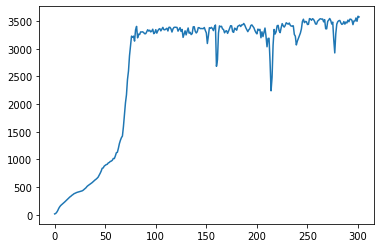

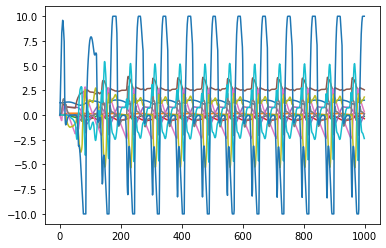

In [7]:
from matplotlib.pyplot import *

trainer_name = 'PPOFrac'
env_name = 'Hopper-v2'
seed_num = 3
checkpoint_path = trainer_dict[trainer_name][env_name][seed_num]
config, df = get_config_and_df(checkpoint_path)
trainer = string_2_trainer[trainer_name](config)
trainer.restore(checkpoint_path)
env = trainer.env_creator({})
o,a,r,l = do_rollout_rllib(env, trainer, num_steps=1000, deterministic=True, render=True)

o_norm = trainer.workers.local_worker().filters['default_policy'](o)
target = o[200:]
target = trainer.workers.local_worker().filters['default_policy'](target)


ms = mdim_stable(o_norm,a,r)
m, c, _, _ = mesh_dim(target, init_d=1e-6)


plot(df['episode_reward_mean'])
print(f"m:{m} c:{c} ms:{ms}")
figure()
plot(o);
print(sum(r))

In [8]:
sampled_act, _, out_dict = trainer.compute_action(o[0,:], full_fetch=True)
means = out_dict['action_dist_inputs']
means = means[:len(means)//2]
print(sampled_kyact, means)


[1. 1. 1.] [2.9471662 1.6827037 1.3315685]


In [9]:
gym.make("MinitaurBulletEnv-v0")

current_dir=/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/pybullet_envs/bullet
urdf_root=/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/pybullet_data


/home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<TimeLimit<MinitaurBulletEnv<MinitaurBulletEnv-v0>>>

In [10]:
env.observation_space.shape

(11,)